In [97]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as LogNorm
import matplotlib.ticker as ticker
import math
#from lmfit import Model
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.odr import ODR, Model, RealData
import ROOT

In [98]:
tfile_hist = [f"../histograms/analysis_note/theta_phi_{i}.root" for i in [10.2, 10.4, 10.6] ]
tfile_func = [f'../data/acceptance_map/acceptanceMap_{i}.root' for i in [10.2, 10.4, 10.6] ]
par_list = ['e', 'pip', 'pim']
par_tit = ['e', r'{\pi^+}', r'{\pi^-}']
hBase = 'hThetaPhi_sec'
fBase = 'fThetaPhi_sec'
vBase = 'fitBounds_sec'

In [99]:
def eval_lower(par, params, xVal):
    if par == 'e':
    	return params[0]*(xVal - params[1])**2 + params[2]
    else:
    	return params[0]*(xVal - params[1])**4 + params[2]

In [100]:
phi_avg = 0
side = 1
parIdx = 0

theta_min_fixed = 0

def trapezoid(x, x0, x1, x2, x3, height):
    return np.piecewise(
        x,
        [x < x0,
         (x >= x0) & (x < x1),
         (x >= x1) & (x < x2),
         (x >= x2) & (x <= x3),
         x > x3],
        [0,
         lambda x: ((x - x0) / (x1 - x0)) * height,
         height,
         lambda x: ((x3 - x) / (x3 - x2)) * height,
         0]
    )

def expo(x, a, b, c, d):
  
    return a*np.exp(b*x+c)+d
def poly3(x, a, b, c, d):

    return a + b*x + c*x**2 + d*x**3

def getPercentile( arr, nBins, perc ):
    for i in range(nBins):
        if np.sum(arr[:i])/np.sum(arr) > 0.01*perc:
            return i
    return 0

def lorGauss(x, mu, sig1, sig2, A, cutoff):
    switchOver = A/(np.pi)*((sig2)/((cutoff-mu)**2 + sig2**2))
    return np.piecewise(
        x,
        [x < cutoff - switchOver/sig1,
            (x >= cutoff - switchOver/sig1) & (x < cutoff),
         x >= cutoff],
        [
         0,
         lambda x: sig1*(x-cutoff) + switchOver,#lambda x: A*np.exp(-(x - mu)**2 / (2 * sig1**2)),
         lambda x: A/(np.pi)*((sig2)/((x-mu)**2 + sig2**2))
        ]
    )
    

def linGauss(x, mu, sig1, sig2, A, cutoff):
    
    switchOver = A*np.exp(-(cutoff - mu)**2 / (2 * sig2**2))

    return np.piecewise(
        x,
        [x < cutoff - switchOver/sig1,
            (x >= cutoff - switchOver/sig1) & (x < cutoff),
         x >= cutoff],
        [
         0,
         lambda x: sig1*(x-cutoff) + switchOver,#lambda x: A*np.exp(-(x - mu)**2 / (2 * sig1**2)),
         lambda x: A*np.exp(-(x - mu)**2 / (2 * sig2**2))
        ]
    )

def returnXint(mu, sig1, sig2, A, cutoff):
    return cutoff - A*np.exp(-(cutoff - mu)**2 / (2 * sig2**2))/sig1

def doubleGauss(x, mu, sig1, sig2, A, cutoff):
    
    return np.piecewise(
        x,
        [x < mu,
            x >= mu
        ],
        [
         lambda x: A*np.exp(-(x - mu)**2 / (2 * sig1**2)),
         lambda x: A*np.exp(-(x - mu)**2 / (2 * sig2**2))
        ]
    )

def phiFunction_map(x, a, b, c, phi_avg, parIdx, side, max):
    
    #exponent = 1 if parIdx in [0,2] else 1/2
    #denominator = (x - b)/c + 1 if parIdx in [0,2] else np.exp((x - b)/c) + 1
    return np.piecewise(

        x,
        [x < b,
         (x >= b) & (x < max),
         x>max],
        [lambda x: np.full_like(x, phi_avg),
         lambda x: phi_avg + (side)*a*(1 - 1/( (x - b)/c + 1 if parIdx in [0,2] else np.exp((x - b)/c) + 1)),
         lambda x: np.full_like(x, phi_avg)]
    )
def phiFunction_fixed(x, a, c):
    
    denominator = (x - theta_min_fixed)/c + 1 if parIdx in [0,2] else np.exp((x - theta_min_fixed)/c) + 1
    #exponent = 1 if parIdx in [0,2] else 1/2
    return np.piecewise(

        x,
        [x < theta_min_fixed,
         x >= theta_min_fixed],
        [lambda x: np.full_like(x, phi_avg),
         lambda x:  phi_avg + (side)*a*(1 - 1/( denominator + 1))]
    )

def model_phi(B,x):
    exponent = 1 if parIdx in [0] else 1/2
    return np.piecewise(

        x,
        [x < B[1],
         x >= B[1]],
        [lambda x: np.full_like(x, phi_avg),
         lambda x:  phi_avg + (side)*B[0]*(1 - 1/( (x - B[1])**(exponent)/B[2] + 1))]
    )
model = Model(model_phi)
def fitFunction(pIdx):
    if pIdx == 0:
        return doubleGauss
    else:
        return linGauss


In [101]:
t_range = np.linspace( 5, 45, 180)

offsets = [[100,  200, 300,  0, 50],[-100, -70,0, 50, -280, -180]]
params_0 = [[-15, 1, -0.1],[20, -.8, 0.1]  ]

def plot_phi( parIdx, p, sec):
    hFile = [uproot.open(tfile_hist[i]) for i in range(3)]

    
    par = par_list[parIdx]
    theta_bins = 180
            
    params=[]
    p_errs=[]
    yVals=[]
    

    p_max = 10
    if parIdx > 0 :
        p_max = 5

    hist = [hFile[i][hBase + f'_{sec}_bin_{p}_{par};1'] for i in range(3)]
    
                    
    values = sum([np.array(hist[i].values()) for i in range(3)])
    xEdges = hist[0].axis(0).centers()
    xExtrema = np.where(np.all(values > 0, axis = 0))[0]
    yEdges = hist[0].axis(1).centers()
    yExtrema = np.where(np.all(values > 0, axis = 1))[0]

    
    for theta in range(270):
                                            
        if np.sum(values[:,theta])<=50:
            continue

        pv = np.where(values[:,theta]>0.65*np.max(values[:,theta]))
        gtz = np.where(values[:,theta]>0)
        
        p0 = [xEdges[gtz[0][0]], 0.5*(xEdges[gtz[0][0]]+xEdges[pv[0][0]]), 0.5*(xEdges[pv[0][-1]]+xEdges[pv[0][-1]]),xEdges[gtz[0][-1]], 0.75*np.max(values[:,theta])]

        try:
            popt, pcov = curve_fit(trapezoid, xEdges, values[:,theta], p0)
        except RuntimeError as e:
            #print("Failed phi fit")
            continue
        if popt[0] > popt[1] or popt[1] > popt[2] or popt[2] > popt[3]:
            continue
        #if popt[1] > (popt[0]+popt[3])/2. or popt[2] < (popt[0]+popt[3])/2.:
        #    continue

        perr = np.sqrt(np.diag(pcov))
        
        if popt[0] <xEdges[gtz[0][0]] or popt[3] > xEdges[gtz[0][-1]]:
            continue
        
        params.append([popt[i] for i in range(4)])       
        p_errs.append([perr[i] for i in range(4)])
        yVals.append(yEdges[theta])

    return np.asarray(params), np.asarray(p_errs), np.asarray(yVals)
    

   
            

In [102]:
def plot_fit(parIdx, p, sec, ax):
    hFile_0 = uproot.open(tfile_hist[0])
    hFile_1 = uproot.open(tfile_hist[1])
    hFile_2 = uproot.open(tfile_hist[2])

    
    par = par_list[parIdx]
    p_max = 8 if parIdx == 0 else 5
    p_min = 3 if parIdx == 0 else 0
   
   
    ax.set_title(f"{par_list[parIdx]}, {p*(p_max-p_min)/40.+p_min} < p < {(p+1)*(p_max-p_min)/40. + p_min}")


    hist_0 = hFile_0[hBase + f'_{sec}_bin_{p}_{par};1']
    hist_1 = hFile_1[hBase + f'_{sec}_bin_{p}_{par};1']
    hist_2 = hFile_2[hBase + f'_{sec}_bin_{p}_{par};1']
                    
    values = hist_0.values() + hist_1.values() + hist_2.values()            
    values[values==0] = np.nan
    xEdges = hist_0.axis(0).centers()
    yEdges = hist_0.axis(1).centers()

 
    ax.pcolormesh(yEdges, xEdges, np.transpose(values.T), cmap='viridis', shading='nearest')
   
    #ax.set_ylim(-100, 100)
    
 

In [103]:
def getHistMean(parIdx, p, sec):
    hFile_0 = uproot.open(tfile_hist[0])
    hFile_1 = uproot.open(tfile_hist[1])
    hFile_2 = uproot.open(tfile_hist[2])

    
    par = par_list[parIdx]

    hist_0 = hFile_0[hBase + f'_{sec}_bin_{p}_{par};1']
    hist_1 = hFile_1[hBase + f'_{sec}_bin_{p}_{par};1']
    hist_2 = hFile_2[hBase + f'_{sec}_bin_{p}_{par};1']
                    
    bin_contents = hist_0.values() + hist_1.values() + hist_2.values()            
                    
    x_centers = np.asarray(hist_0.axis(0).centers())
    y_centers = np.asarray(hist_0.axis(1).centers())

    values_theta = np.sum(bin_contents, axis=0)
    bound_ind = getPercentile(values_theta, 270, 99)
    max_theta = y_centers[bound_ind]

 
    total_entries = np.sum(bin_contents)

    if total_entries == 0:
        print("The histogram is empty.")
    else:
    # Weighted average for x-axis
    # Reshape bin_contents to match the shape of x_centers for broadcasting
    # or use np.sum with the correct axis.
        sum_x = np.sum(x_centers * np.sum(bin_contents, axis=1))
        mean_x = sum_x / total_entries

        # Weighted average for y-axis
        sum_y = np.sum(y_centers * np.sum(bin_contents, axis=0))
        mean_y = sum_y / total_entries

        return mean_y, mean_x, max_theta
    

In [104]:
def studyPoints( low, xVals ):
    fig = plt.figure()
    ax=fig.add_subplot(111)


    ax.plot(np.abs(low[1:] - low[:-1]), label='low')
    ax.plot(np.abs(xVals[1:] - xVals[:-1]), label='xVals')
    ax.plot((low[1:] - low[:-1])/(xVals[1:] - xVals[:-1]), label='ratio')
    ax.legend()
    ax.set_ylim(-1, 1)

In [105]:

phi_range = np.linspace(0,45, 500)
cut_0 =[25, 10, 24]
def plot_theta( parIdx, p, sec):
    
    hFile = [uproot.open(tfile_hist[i]) for i in range(3)]

    
    par = par_list[parIdx]
            
    
    low = []
    low_err = []
    xVals=[]
    

    #ax.set_title(f"{par_list[parIdx]}, {p*p_max/20.} < p < {(p+1)*p_max/20.}")

    hist = [hFile[i][hBase + f'_{sec}_bin_{p}_{par};1'] for i in range(3)]
    
                    
    values = sum([np.array(hist[i].values()) for i in range(3)])
    xEdges = hist[0].axis(0).centers()
    yEdges = hist[0].axis(1).centers()

    for phi in range(500):
        if np.sum(values[phi])<=50:
            continue
    
        #fig = plt.figure()
        #ax=fig.add_subplot(111)
        #ax.plot(yEdges, values[phi])
        #ax.set_title(f"phi = {-250 + phi}")
        max_theta_idx = np.where(values[phi]>.9*np.max(values[phi]))
        max_theta_idx_cut = np.where(values[phi]>0.8*np.max(values[phi]))
        p0 = [yEdges[max_theta_idx[0][0]],1, 5, np.max(values[phi]), cut_0[parIdx]]
        
        gtz = np.where(values[phi,:]>0)[0]
        try:
            popt, pcov = curve_fit(doubleGauss, yEdges, values[phi], p0=p0)
        except RuntimeError as e:
            print("Theta fit failed")
            continue
        if parIdx > 0:
            std_dev = np.sqrt(np.average((yEdges - np.average(yEdges, weights=values[phi]))**2, weights=values[phi]))
            
            p0 = [yEdges[max_theta_idx[0][0]],200, std_dev, np.max(values[phi]), (yEdges[max_theta_idx_cut[0][0]])]
            try:
                popt, pcov = curve_fit(linGauss, yEdges, values[phi], p0=p0)
            except RuntimeError as e:
                #print("Theta Fit Failed")
                continue
        if parIdx > 0 and popt[4] < yEdges[gtz[0]]-5:
            continue
        if parIdx == 0 and popt[0] < yEdges[gtz[0]]:
            continue

        perr = np.sqrt(np.diag(pcov))
        #ax.plot(phi_range, fitFunction(parIdx)(phi_range, *popt))
        if parIdx > 0:
            #low.append(returnXint(*popt))
            low.append(popt[4])
            low_err.append(perr[4])
            #low_err.append(popt[4] - returnXint(*popt))
        else:
            low.append(popt[0])
            low_err.append(perr[1])
        xVals.append(xEdges[phi])

    return np.asarray(low), np.asarray(low_err), np.asarray(xVals)

In [106]:
import numpy as np

def fix_errors(sx, sy, min_val=1e-8):
    """
    Fix sx and sy error arrays for ODR fitting.

    Parameters:
    - sx: array-like, errors in x
    - sy: array-like, errors in y
    - min_val: float, small positive value to replace zeros (default 1e-8)

    Returns:
    - sx_fixed, sy_fixed: numpy arrays with zeros replaced by min_val
    """
    sx = np.array(sx, dtype=np.float64)
    sy = np.array(sy, dtype=np.float64)

    # Replace NaN or negative values with min_val (optional, can customize)
    sx = np.where((np.isnan(sx)) | (sx < 0), min_val, sx)
    sy = np.where((np.isnan(sy)) | (sy < 0), min_val, sy)

    # Replace zeros with min_val
    sx_fixed = np.where(sx == 0, min_val, sx)
    sy_fixed = np.where(sy == 0, min_val, sy)

    # Ensure no point has both sx and sy zero (should be rare if replaced above)
    both_zero_mask = (sx_fixed == 0) & (sy_fixed == 0)
    if np.any(both_zero_mask):
        sx_fixed[both_zero_mask] = min_val
        sy_fixed[both_zero_mask] = min_val

    
    return sx_fixed, sy_fixed


In [107]:
def scanROI(x_values, y_values, condition):
    final_x = []
    final_y = []
    size = len(y_values)
    out_size = len(final_x)

    for i in range(size-1):
        slope = np.abs((y_values[i+1] - y_values[i])/(x_values[i+1] - x_values[i]))
        if slope < condition:
            final_x.append(x_values[i])
            final_y.append(y_values[i])
    return np.array(final_x), np.array(final_y)


In [108]:
#for i in [0]:#range(0,3):
def doAnalysis(parIdx):

    i=parIdx
    side = 1
    phi_avg =0
    theta_min_fixed = 0

    def phiFunction(x, a, b, c):
        
        #exponent = 1 if parIdx in [0,1,2] else 1/2
        denominator = (x - b)/c + 1 if parIdx in [0,2] else np.exp((x - b)/c) + 1
        return np.piecewise(

            x,
            [x < b,
            x >= b],
            [lambda x: np.full_like(x, phi_avg),
            lambda x:  phi_avg + (side)*a*(1 - 1/( ((x - b)/c + 1 if parIdx in [0,2] else np.exp((x - b)/c) + 1) ))]
        )
    def phiFunction_fixed(x, a, c):
       
        #exponent = 1 if parIdx in [0,1,2] else 1/2
        denominator = (x - theta_min_fixed)/c + 1 if parIdx in [0,2] else np.exp((x - theta_min_fixed)/c) + 1
        return np.piecewise(

            x,
            [x < theta_min_fixed,
            x >= theta_min_fixed],
            [lambda x: np.full_like(x, phi_avg),
            lambda x:  phi_avg + (side)*a*(1 - 1/( ((x - theta_min_fixed)/c + 1 if parIdx in [0,2] else np.exp((x - theta_min_fixed)/c) + 1)))]
        )

    params_l1 = [[] for i in range(6)]
    params_l2 = [[] for i in range(6)]
    params_l3 = [[] for i in range(6)]
    params_u1 = [[] for i in range(6)]
    params_u2 = [[] for i in range(6)]

    errs_l1 = [[] for i in range(6)]
    errs_l2 = [[] for i in range(6)]
    errs_l3 = [[] for i in range(6)]
    errs_u1 = [[] for i in range(6)]
    errs_u2 = [[] for i in range(6)]
   


    p_low = 0 if i == 0 else 6
    p_high = 32 if i == 0 else 40
    Range = range(p_low, p_high) if i==0 else reversed(range(p_low, p_high))
    p0 = [8, 8, 1.5]
    for p in Range:#reversed(range(p_low,7)):
       
        
        #fig, ax = plt.subplots(1, 2, figsize=(10,12), layout='constrained')
        for sector in [0,1,2,3,4,5]:
            pan = 0 if sector in [1,2,3] else 1
            low, low_err, xVals = plot_theta( i, p, sector)#axs[math.floor(sector/2), sector%2]
         
            params, perr, yVals = plot_phi(i, p, sector)
            up_err = perr[:,1]
            bot_err = perr[:,2]
            params=np.asarray(params)
            
            #plot_fit(i, p, sector, ax[pan])
            y_mean, x_mean, max_theta = getHistMean(i, p, sector)
            low_val = np.min(low) if np.min(low) > 0 else 10
        

            #ax[0].set_xlim(low_val-5, 35)
            #ax[1].set_xlim(low_val-5, 35)

            #ax[0].set_ylim(0, 225)
            #ax[1].set_ylim(-175,25)

            
            #ax[pan].plot( yVals, params[:,1] , color='red',ms=2, marker='o', linestyle=' ') #bottom line
            #ax[pan].plot( yVals, params[:,2], color='red', marker='o', linestyle=' ',ms=2)
            #ax[pan].plot( low, xVals, marker='+', ms = 4, linestyle=' ', color='red')

            phi_avg = x_mean
            
            slope_phi_1 = np.abs((params[:,1][1:] - params[:,1][:-1])/(yVals[1:] - yVals[:-1]))
            slope_phi_2 = np.abs((params[:,2][1:] - params[:,2][:-1])/(yVals[1:] - yVals[:-1]))
            
            bad_mask = np.insert(slope_phi_1>1, 0, False)
            params_1 = np.where(bad_mask, np.nan, params[:,1])
            params_1 = params_1[~np.isnan(params_1)]
            yVals_1 = np.where(bad_mask, np.nan, yVals)
            yVals_1 = yVals_1[~np.isnan(yVals_1)]
            bot_err = np.where(bad_mask, np.nan, bot_err)
            bot_err = bot_err[~np.isnan(bot_err)]

            bad_mask = np.insert(slope_phi_2>1, 0, False)
            params_2 = np.where(bad_mask, np.nan, params[:,2])
            params_2 = params_2[~np.isnan(params_2)]
            yVals_2 = np.where(bad_mask, np.nan, yVals)
            yVals_2 = yVals_2[~np.isnan(yVals_2)]
            up_err = np.where(bad_mask, np.nan, up_err)
            up_err = up_err[~np.isnan(up_err)]

            yVals_1=yVals
            yVals_2=yVals
            params_1=params[:,1]
            params_2=params[:,2]
            #xVals, low =scanROI(xVals, low,1)
           


            #slope_theta = np.abs((low[1:] - low[:-1])/(xVals[1:] - xVals[:-1]))
            #bad_mask = np.insert(slope_theta>1, 0, False )#>1, 0, False)    
            #xVals = np.where(bad_mask, np.nan, xVals)
            #low = np.where(bad_mask, np.nan, low)
            
            mom = 3*(parIdx < 1) + p*1/8


            low_mask = (xVals < x_mean)#&(xVals < np.min(params_2))
            high_mask = (xVals>= x_mean)#&(xVals >= np.min(params_1))
            
            low_vals = low[low_mask]
            high_vals = low[high_mask]
            
            xVals_low = xVals[low_mask]
            xVals_high = xVals[high_mask]
        

            if( parIdx == 1 and  mom < 1.125):
                xVals_low = np.asarray([phi_avg - n for n in range(np.maximum( np.abs(int(phi_avg -np.max( params_1)) ), np.abs(int(phi_avg -np.min( params_2)) )))])
                xVals_high = np.asarray([phi_avg + n for n in range( np.maximum( np.abs(int(phi_avg -np.max( params_1)) ), np.abs(int(phi_avg -np.min( params_2)) )))])

                set_val = np.maximum((p0[1]+p0[1])/2, np.maximum(np.min(yVals_1), np.min(yVals_2)))

                low_vals = np.asarray([ set_val for n in range(np.maximum( np.abs(int(phi_avg -np.max( params_1)) ), np.abs(int(phi_avg -np.min( params_2)) )))])
                high_vals = np.asarray([ set_val for n in range(np.maximum( np.abs(int(phi_avg -np.max( params_1)) ), np.abs(int(phi_avg -np.min( params_2)) )) )])

                #print(low_vals, xVals_low)
                #print(high_vals, xVals_high)

            #ax[pan].plot( yVals_1, params_1, color='cyan',ms=2, marker='o', linestyle=' ') #bottom line
            #ax[pan].plot( yVals_2, params_2, color='cyan', marker='o', linestyle=' ',ms=2)
            #ax[pan].plot( low, xVals, marker='+', ms = 4, linestyle=' ', color='cyan')
        
            
            

            #Select which side on, also select region for theta slices

            low_vals = np.append(low_vals, yVals_1[(params_1 < x_mean) & (yVals_1 > np.min(low_vals)) ])
            xVals_low = np.append(xVals_low, params_1[(params_1 < x_mean) & (yVals_1 > np.min(low_vals)) ])
            

            high_vals = np.append(high_vals, yVals_2[(params_2 > x_mean) & (yVals_2 > np.min(high_vals)) ])
            xVals_high = np.append(xVals_high, params_2[(params_2 > x_mean) & (yVals_2 > np.min(high_vals)) ])
            
            
            #ax[pan].plot( low_vals, xVals_low, marker='.', ms = 4, linestyle=' ', color='white')
            #ax[pan].plot( high_vals, xVals_high, marker='.', ms = 4, linestyle=' ', color='white')



            side = -1


        
            #ax[pan].plot( phi_range, phiFunction(phi_range, *output_up.beta), color='red')
            popt_up, pcov_up = curve_fit(phiFunction, low_vals, xVals_low, nan_policy='omit', p0 = p0)
            
            perr_up = np.sqrt(np.diag(pcov_up))
            p0 = popt_up#output_up.beta#popt_up
            
            side=1
            popt_low, pcov_low = curve_fit(phiFunction, high_vals, xVals_high, nan_policy='omit',p0 = p0)
            perr_low = np.sqrt(np.diag(pcov_low))
            #low_err_y, low_err_x = fix_errors(low_err_y, low_err_x, 1e-8)
            #data_lower = RealData(low_vals, xVals_low)#, sx=low_err_x, sy=low_err_y)
            #odr_lower = ODR(data_lower, model, beta0= p0)
            #output_low = odr_lower.run()
            #ax[pan].plot( phi_range, phiFunction(phi_range, *output_low.beta),color='red')
            p0 = popt_low
            theta_min_fixed = (popt_low[1]+popt_up[1])/2
            theta_min_err = 0.5*np.sqrt((perr_up[1])**2 + (perr_low[1])**1)

            p0_2 = [(popt_up[j]+popt_low[j])/2 for j in [0,2]]
            
            side = -1
            popt_up, pcov_up = curve_fit(phiFunction_fixed, low_vals, xVals_low, nan_policy='omit', p0 = p0_2)
            side=1
            popt_low, pcov_up = curve_fit(phiFunction_fixed, high_vals, xVals_high, nan_policy='omit', p0 =p0_2)
            

            side=-1
            #ax[pan].plot( phi_range, phiFunction_fixed(phi_range, *popt_up),color='red')
            side=1
            #ax[pan].plot( phi_range, phiFunction_fixed(phi_range, *popt_low),color='red')

        

            perr_low = np.sqrt(np.diag(pcov_low))
            perr_up = np.sqrt(np.diag(pcov_up))

            insIdx = 0 if parIdx > 0 else np.size(params_l1[sector])

            params_l1[sector].insert(insIdx, popt_low[0])
            params_l2[sector].insert(insIdx,popt_low[1])
            params_l3[sector].insert(insIdx,theta_min_fixed)

            params_u1[sector].insert(insIdx,popt_up[0])
            params_u2[sector].insert(insIdx,popt_up[1])
            
            errs_l1[sector].insert(insIdx,perr_low[0])
            errs_l2[sector].insert(insIdx,perr_low[1])
            errs_l3[sector].insert(insIdx,theta_min_err)


            errs_u1[sector].insert(insIdx,perr_up[0])
            errs_u2[sector].insert(insIdx,perr_up[1])

    return params_l1, params_l2, params_l3,  params_u1, params_u2,errs_l1, errs_l2, errs_l3, errs_u1, errs_u2

            #params_u3[sector].append(popt_up[2])


In [109]:
params_l1, params_l2, params_l3,  params_u1, params_u2,errs_l1, errs_l2, errs_l3, errs_u1, errs_u2 = doAnalysis(0)

/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/2862971360.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(doubleGauss, yEdges, values[phi], p0=p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/30804132.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(trapezoid, xEdges, values[:,theta], p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/3484972210.py:18: RuntimeWarning: invalid value encountered in divide
  lambda x: ((x3 - x) / (x3 - x2)) * height,


Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed
Theta fit failed


In [110]:
#electron and pip functions
def func_theta_min_el(x, p0, p1, p2, p3, p4, p5):
    return p0+ p1/x**2 +p2*x+ p3/x + p4*np.exp(p5*x) 
def func_el_a(x, p0, p1, p2, p3):
    return p0 + p1*np.exp(p2*(x-p3))
def func_el_b(x, p0, p1, p2, p3):
    return p0 + p1*x*np.exp(p2*(x-p3)**2)

def func_pim_a(x, p0, p1, p2, p3):
    return p0 - p1*np.arctan(p2*(x-p3))
def func_pim_b(x, p0, p1, p2, p3):
    return func_el_b(x, p0, p1, p2, p3)

def returnMap(x, p, theta_params, params, sector, phi_avg, parIdx, max):
    minimum_theta = func_theta_min_el(p, *theta_params[sector])   
    param_a_l, param_a_u, param_b_l, param_b_u = 0,0,0,0 
    
    
    param_a_l = func_el_a(p, *params[0][sector]) if parIdx < 2 else func_el_b(p, *params[0][sector])
    param_a_u =  func_el_a(p, *params[1][sector]) if parIdx < 2 else func_el_b(p, *params[1][sector])

    param_b_l =  func_el_b(p, *params[2][sector]) if parIdx < 2 else func_pim_b(p, *params[2][sector])
    param_b_u =  func_el_b(p, *params[3][sector]) if parIdx < 2 else func_pim_b(p, *params[3][sector])


    

  
    l_map = phiFunction_map(x, param_a_l,  minimum_theta, param_b_l,phi_avg, parIdx, -1, max)
    
    u_map = phiFunction_map(x, param_a_u,  minimum_theta, param_b_u, phi_avg, parIdx, 1, max) 

    return l_map, u_map






/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/4229445959.py:5: RuntimeWarning: overflow encountered in exp
  return p0 + p1*np.exp(p2*(x-p3))
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/364734831.py:61: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_t, pcov_t = curve_fit(func_theta_min_el, e_range, params_l3[i][0:32], sigma=errs_l3[i][0:32], p0=p0[i][0:32], maxfev=15000)


[ 5.84861426e+00 -1.67061853e+01 -3.09817183e-02  2.50890974e+01
 -3.07624139e-05 -6.09020516e-01]
[ 6.80366338e+00 -1.06922876e+01 -7.21202028e-02  2.04659102e+01
  3.10056252e-04 -1.13312136e+01]
[ 7.01926496e+00 -1.00229833e+01 -1.03486984e-01  2.01825525e+01
 -1.16545580e-11  3.13995767e+00]
[ 6.50394254e+00 -1.04346821e+01 -5.58532027e-02  2.12387816e+01
 -6.69520584e-06  1.32799916e+00]
[ 6.06596040e+00 -1.34391234e+01 -2.69100887e-02  2.33448384e+01
  1.78640417e-04 -5.85487342e+00]
[ 6.75799254e+00 -1.08045124e+01 -7.58133203e-02  2.04002051e+01
 -8.32951521e-05 -1.31389726e-01]
[array([ 5.84861426e+00, -1.67061853e+01, -3.09817183e-02,  2.50890974e+01,
       -3.07624139e-05, -6.09020516e-01]), array([ 6.80366338e+00, -1.06922876e+01, -7.21202028e-02,  2.04659102e+01,
        3.10056252e-04, -1.13312136e+01]), array([ 7.01926496e+00, -1.00229833e+01, -1.03486984e-01,  2.01825525e+01,
       -1.16545580e-11,  3.13995767e+00]), array([ 6.50394254e+00, -1.04346821e+01, -5.5853202

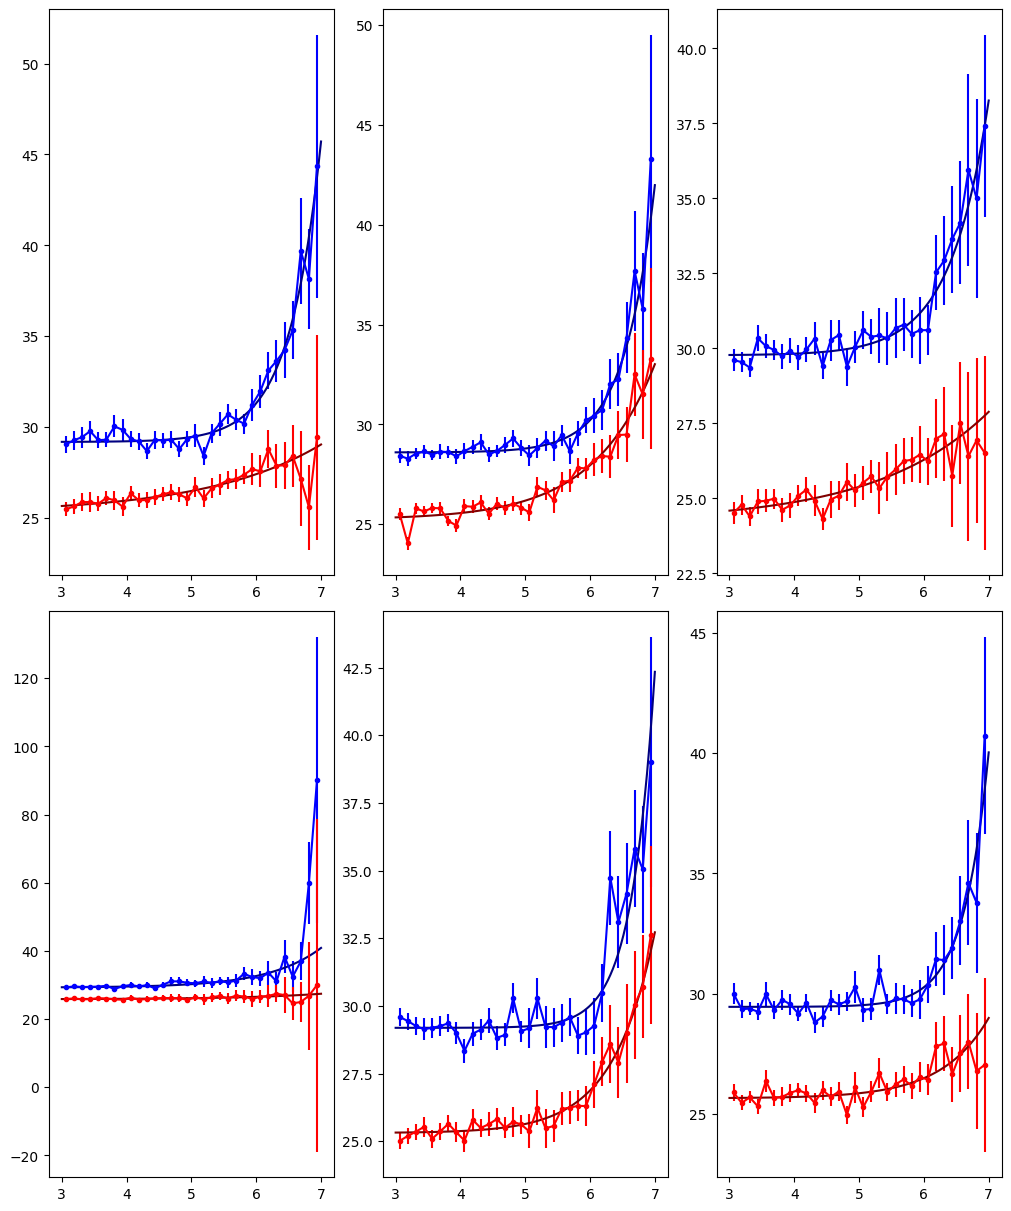

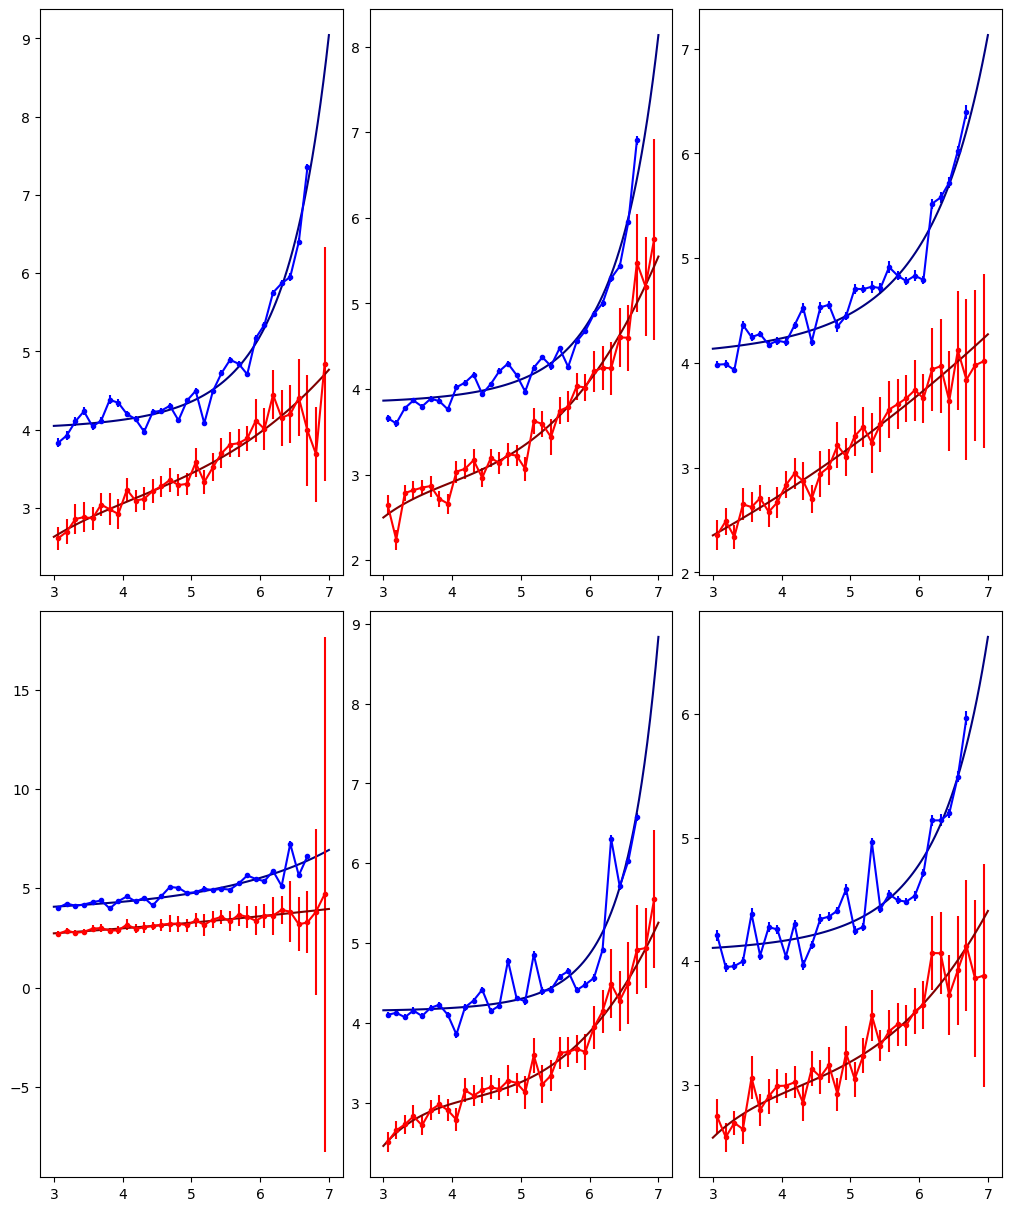

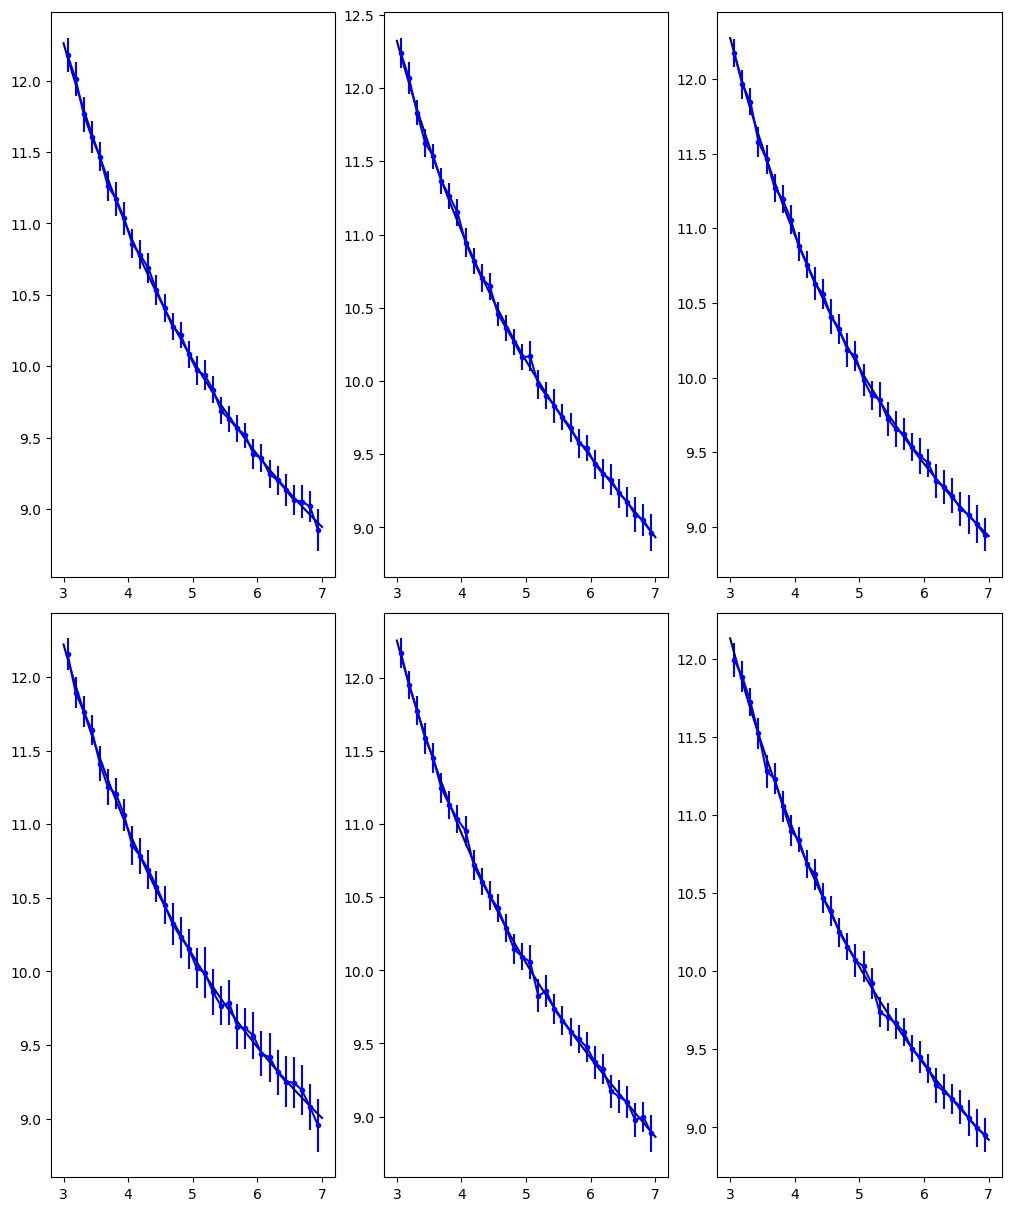

In [130]:
el_theta_min_params =[]
e_params = [[] for i in range(4)]
e_range = np.linspace( 3 + (8-3)/80, 7 - 5/80, 32)
fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')

p0=[[25.79642158 , 0.32553469 , 1.65775928 , 5.14181306],
[25.79642158 , 0.32553469 , 1.65775928 , 5.14181306],
[25.37375984  ,3.06278176 , 1.29688327 , 6.41201586],
[25.19503825 , 0.12025548 , 2.02225004 , 4.76531634],
[24.52673308 , 0.36006969 , 0.88506298 , 4.57135557],
[25.59834641 , 0.05889342 , 2.41163106 , 5.08739491]]

for i in range(0,6):
    ax[i%2, math.floor(i/2)].errorbar(e_range, params_l1[i][0:32], errs_l1[i][0:32], marker = '.', linestyle='-', color='blue')
    popt_a, pcov_a = curve_fit(func_el_a, e_range, params_l1[i][0:32], sigma=errs_l1[i][0:32], p0=[29.01676893,  3.35532212,  1.91288859,  6.49735858])
    ax[i%2, math.floor(i/2)].plot(np.linspace(3, 7, 100), func_el_a(np.linspace(3, 7, 100), *popt_a), color='navy')

    e_params[0].append(popt_a)

    ax[i%2, math.floor(i/2)].errorbar(e_range, params_u1[i][0:32], errs_u1[i][0:32], marker = '.', linestyle='-', color='red')
    popt_a, pcov_a = curve_fit(func_el_a, e_range, params_u1[i][0:32], sigma=errs_u1[i][0:32], p0=p0[i][0:32], maxfev=1000000)
    ax[i%2, math.floor(i/2)].plot(np.linspace(3, 7, 100), func_el_a(np.linspace(3, 7, 100), *popt_a), color='maroon')
    e_params[1].append(popt_a)
fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')

p0=[
[3.67070278, 0.06004964, 0.18021776, 3.2877174 ],
[-2.44576369, 1.05193331, 0.0444404,  6.42218139],
[3.54074658, 0.07082834, 0.12991039, 2.92328984],
[3.81586986, 0.04470739, 0.28428386, 3.69236709],
[3.85189111, 0.03299414, 0.24744023, 3.3726926 ],
[3.85189111, 0.03299414, 0.24744023, 3.3726926 ]]

for i in range(0,6):
    
    ax[i%2, math.floor(i/2)].errorbar(e_range[0:-2], params_l2[i][0:30], errs_l2[i][0:30], marker = '.', linestyle='-', color = 'blue')
    popt_b, pcov_b = curve_fit(func_el_b, e_range[0:-2], params_l2[i][0:30], sigma=errs_l2[i][0:30], p0 =p0[i][0:30], maxfev=1500000)
    ax[i%2, math.floor(i/2)].plot(np.linspace(3, 7, 100), func_el_b(np.linspace(3, 7, 100), *popt_b), color= 'navy')
    e_params[2].append(popt_b)

    ax[i%2, math.floor(i/2)].errorbar(e_range, params_u2[i][0:32], errs_u2[i][0:32], marker = '.', linestyle='-', color = 'red')
    popt_b, pcov_b = curve_fit(func_el_b, e_range, params_u2[i][0:32], sigma=errs_u2[i][0:32], p0 =[-2.44576369, 1.05193331, 0.0444404,  6.42218139], maxfev=150000)
    ax[i%2, math.floor(i/2)].plot(np.linspace(3, 7, 100), func_el_b(np.linspace(3, 7, 100), *popt_b), color= 'maroon')
    e_params[3].append(popt_b)
    
fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')
p0 = [[5.80421027e+00, -1.44454221e+01 , 6.22691652e-04 , 2.36592337e+01,
  3.28999322e-06 , 1.36728664e+00],
      [5.80421027e+00, -1.44454221e+01 , 6.22691652e-04 , 2.36592337e+01,
  3.28999322e-06 , 1.36728664e+00],
[  -6.25527368, -101.87371682,    1.44266018 ,  82.69214178,   -0.13908512, 0.5716702 ],
[ 8.05825836,  8.41737744,  1.07303332 , 9.90951454, -0.77564392,  0.16463166],
[5.80421027e+00, -1.44454221e+01 , 6.22691652e-04 , 2.36592337e+01,
  3.28999322e-06 , 1.36728664e+00],
[5.80421027e+00, -1.44454221e+01 , 6.22691652e-04 , 2.36592337e+01,
  3.28999322e-06 , 1.36728664e+00]]


for i in range(0,6):
    ax[i%2, math.floor(i/2)].errorbar(e_range, params_l3[i][0:32], errs_l3[i][0:32], marker = '.', linestyle='-', color = 'blue')
    popt_t, pcov_t = curve_fit(func_theta_min_el, e_range, params_l3[i][0:32], sigma=errs_l3[i][0:32], p0=p0[i][0:32], maxfev=15000)
    ax[i%2, math.floor(i/2)].plot(np.linspace(3, 7, 100), func_theta_min_el(np.linspace(3, 7, 100), *popt_t), color= 'navy')

    el_theta_min_params.append(popt_t)
    print(popt_t)
  
print(el_theta_min_params)

In [112]:
params_pip_l1, params_pip_l2, params_pip_l3,  params_pip_u1, params_pip_u2,errs_pip_l1, errs_pip_l2, errs_pip_l3, errs_pip_u1, errs_pip_u2 = doAnalysis(1)

/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/2862971360.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(doubleGauss, yEdges, values[phi], p0=p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/2862971360.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linGauss, yEdges, values[phi], p0=p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/30804132.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(trapezoid, xEdges, values[:,theta], p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/3484972210.py:18: RuntimeWarning: invalid value encountered in divide
  lambda x: ((x3 - x) / (x3 - x2)) * height,
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/2001761883.py:187: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_up, pcov_up 

/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/4229445959.py:5: RuntimeWarning: overflow encountered in exp
  return p0 + p1*np.exp(p2*(x-p3))


[33.84088064 -9.23865473  0.12897826  1.79607756]
[25.153479   -4.17603516  0.99186252  4.57497197]
[ 4.12309212e+03 -1.58576021e+03  2.98089350e-04 -3.18376760e+03]
[ 2.54857403e+03 -9.85346807e+02  4.48977560e-04 -2.09264341e+03]
[ 43.77251767 -13.45401787   0.04973956  -5.50633118]
[25.86864873 -4.09303901  0.43399807  4.25179122]


/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/4229445959.py:7: RuntimeWarning: overflow encountered in exp
  return p0 + p1*x*np.exp(p2*(x-p3)**2)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/4229445959.py:3: RuntimeWarning: overflow encountered in exp
  return p0+ p1/x**2 +p2*x+ p3/x + p4*np.exp(p5*x)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/1993000358.py:70: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_t, pcov_t = curve_fit(func_theta_min_el, pi_range, params_pip_l3[i][1:34], maxfev=15000000,p0=[ 3.93265139e+00, -6.35440228e-01,  1.11616750e+00 , 3.38232829e+00,


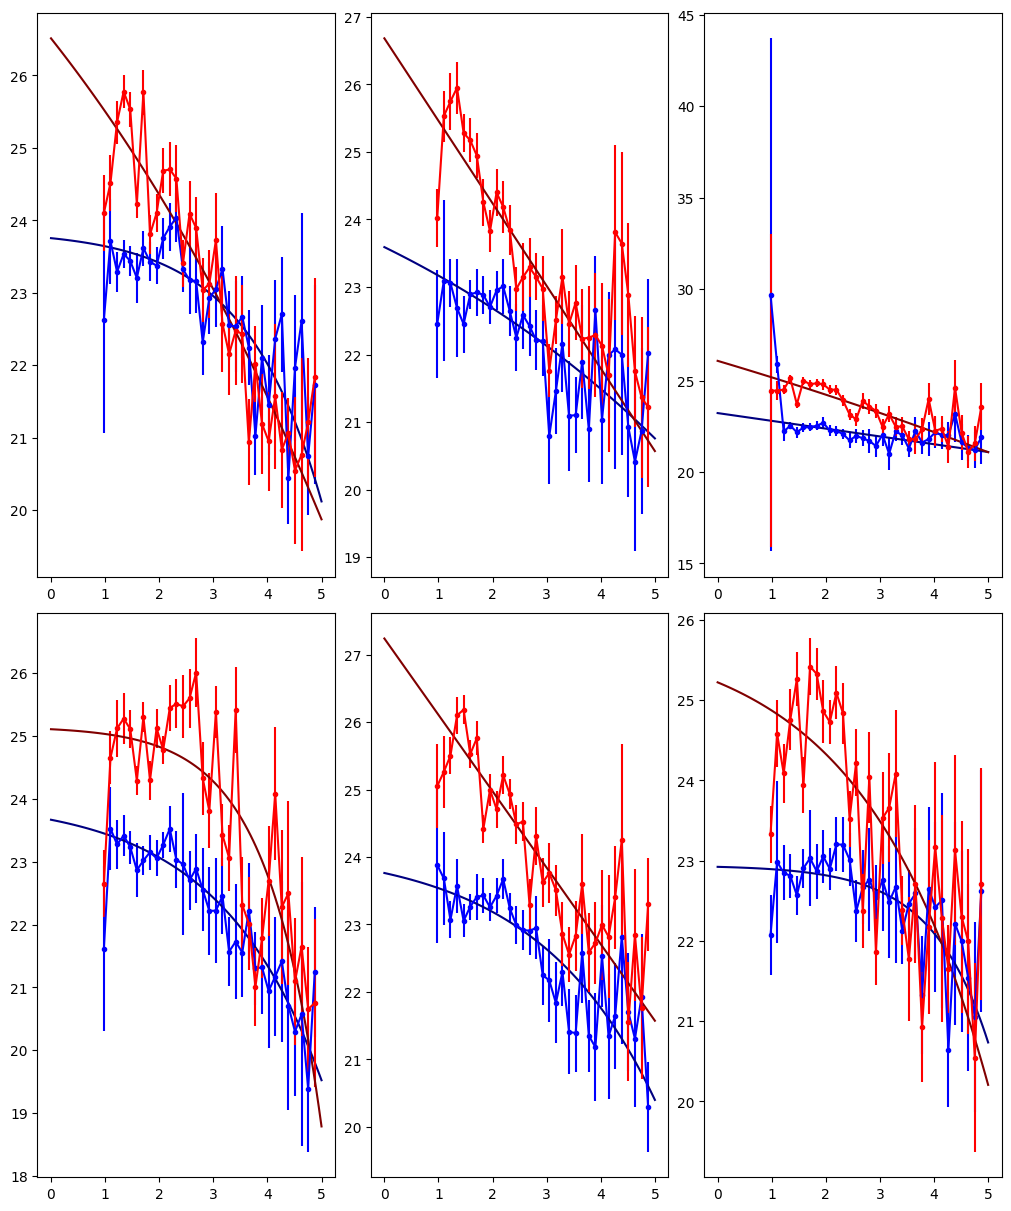

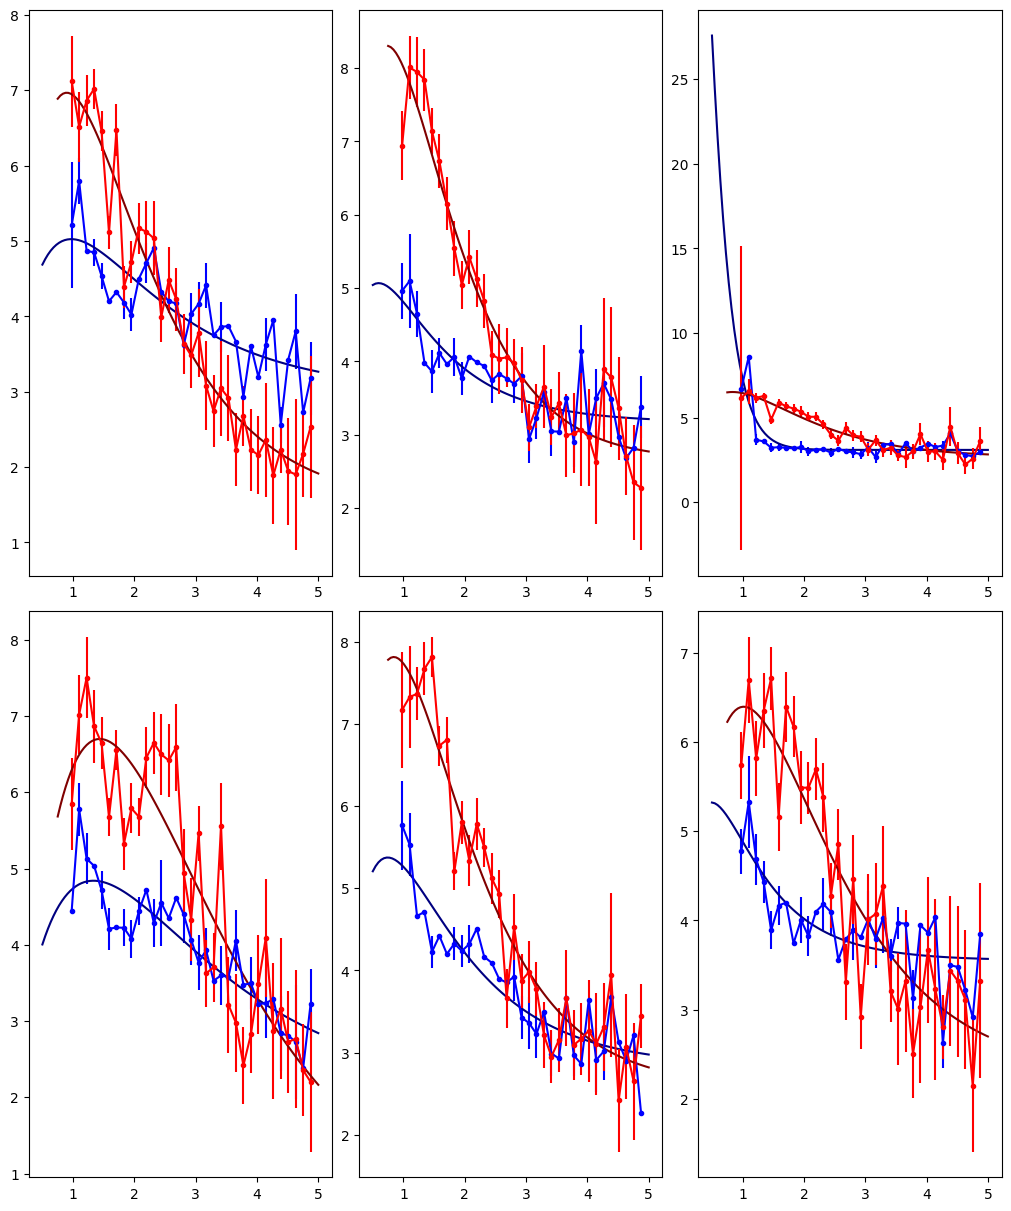

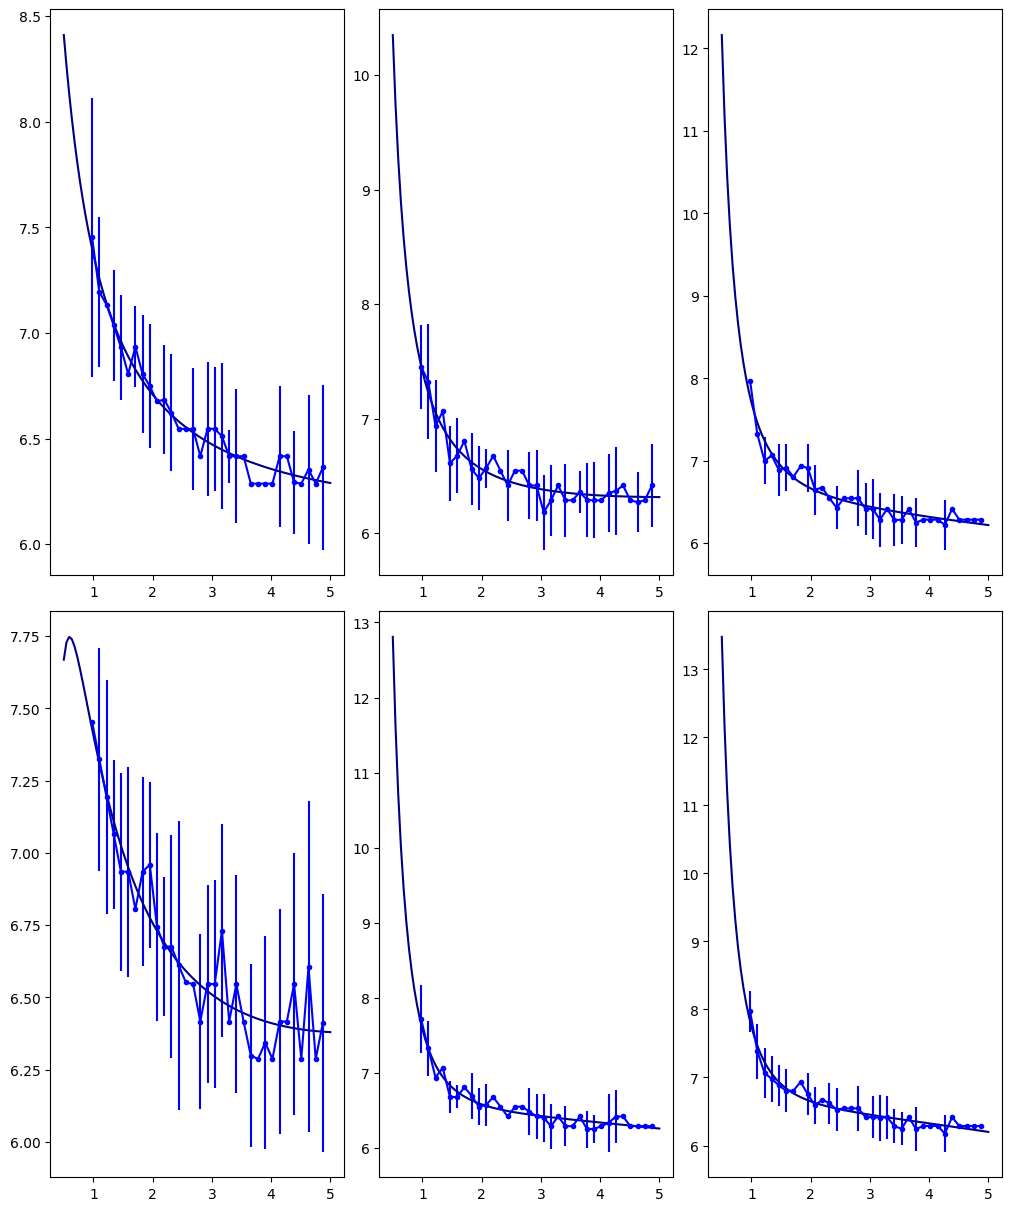

In [113]:
pi_range = np.linspace(0 + (5)/40, 5 - 5/40, 40)[7:40]
fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')
pip_theta_min_params =[]
pip_params = [[] for i in range(4)]


p0 = [
    [32.75239255 ,-5.1851922,  0.59822379 , 1.05829656],
    [ 37.3619118,  -5.21415498 , 0.28460749,  3.36062314],
    [32.75239255 ,-5.1851922,  0.59822379 , 1.05829656],
    [34.02641177, -1.00576906,  0.62178092,  1.3605207  ],
    [ 32.75239255 ,-5.1851922,  0.59822379 , 1.05829656 ],
    [32.75239255 ,-5.1851922,  0.59822379 , 1.05829656]]

p0_2 = [
[ 25.10526297, -1.48492098 ,  1.05417794 ,  6.1916069 ],
[ 25.10526297, -1.48492098 ,  1.05417794 ,  6.1916069 ],
[26.1674015 , 0 , 0.38470821 , 4.44485093],
[26.1674015 , 0 , 0.38470821 , 4.44485093],
[ 25.10526297, -1.48492098 ,  1.05417794 ,  6.1916069 ],
[ 25.10526297, -1.48492098 ,  1.05417794 ,  6.1916069 ]
]

for i in range(0,6):
    
    ax[i%2, math.floor(i/2)].errorbar(pi_range, params_pip_l1[i][1:34],errs_pip_l1[i][1:34], marker = '.', linestyle='-', color='blue')
    popt_a, pcov_a = curve_fit(func_el_a, pi_range, params_pip_l1[i][1:34],sigma = errs_pip_l1[i][1:34], maxfev=1500000, p0=p0[i])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0, 5, 100), func_el_a(np.linspace(0, 5, 100), *popt_a), color='navy')
    pip_params[0].append(popt_a)

    ax[i%2, math.floor(i/2)].errorbar(pi_range, params_pip_u1[i][1:34], errs_pip_u1[i][1:34], marker = '.', linestyle='-', color='red')
    popt_a, pcov_a = curve_fit(func_el_a, pi_range, params_pip_u1[i][1:34],sigma = errs_pip_u1[i][1:34], maxfev=150000, p0=p0_2[i])#[ 25.10526297, -1.48492098 ,  1.05417794 ,  6.1916069 ])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0, 5, 100), func_el_a(np.linspace(0, 5, 100), *popt_a), color='maroon')
    pip_params[1].append(popt_a)
    print(popt_a)
    #ax[i%2, math.floor(i/2)].set_ylim(0, 50)

fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')

p0=[
[ 2.71738185, -0.18481952,  0.13858209,  3.88785433],
[2.71738185, -0.18481952,  0.13858209,  3.8878543],
[2.71738185, -0.18481952,  0.13858209,  3.8878543],
[1.34319222, 0.06033968, 0.4212403, 3.71159105],
[1.34319222, 0.06033968, 0.4212403, 3.71159105],
[0.99058498, 0.14595902, 0.14182083, 5.11437383]
]

for i in range(0,6):
    
    ax[i%2, math.floor(i/2)].errorbar(pi_range, params_pip_l2[i][1:34], errs_pip_l2[i][1:34], marker = '.', linestyle='-', color='blue')
    popt_b, pcov_b = curve_fit(func_el_b, pi_range, params_pip_l2[i][1:34],  maxfev=15000000,p0 =[3.20859722,0.01368572, 0.17229598, 6.30687601])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.5, 5, 100), func_el_b(np.linspace(0.5, 5, 100), *popt_b), color='navy')
    pip_params[2].append(popt_b)

    ax[i%2, math.floor(i/2)].errorbar(pi_range, params_pip_u2[i][1:34], errs_pip_u2[i][1:34], marker = '.', linestyle='-', color='red')
    popt_b, pcov_b = curve_fit(func_el_b, pi_range, params_pip_u2[i][1:34], p0 =[ 2.75394739 , 0.01812153  ,0.05078354 ,10.76588923],maxfev=15000000)
    #print(popt_b)
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.75, 5, 100), func_el_b(np.linspace(0.75, 5, 100), *popt_b), color='maroon')
    pip_params[3].append(popt_b)



fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')

for i in range(0,6):
    
    ax[i%2, math.floor(i/2)].errorbar(pi_range, params_pip_l3[i][1:34], errs_pip_l3[i][1:34], marker = '.', linestyle='-', color='blue')

    popt_t, pcov_t = curve_fit(func_theta_min_el, pi_range, params_pip_l3[i][1:34], maxfev=15000000,p0=[ 3.93265139e+00, -6.35440228e-01,  1.11616750e+00 , 3.38232829e+00,
  1.13480678e-03, -3.57516466e-01])
    #print(popt_t)
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.5, 5, 100), func_theta_min_el(np.linspace(0.5, 5, 100), *popt_t), color='navy')
    pip_theta_min_params.append(popt_t)

   

In [114]:
params_pim_l1, params_pim_l2, params_pim_l3,  params_pim_u1, params_pim_u2,errs_pim_l1, errs_pim_l2, errs_pim_l3, errs_pim_u1, errs_pim_u2 = doAnalysis(2)

/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/2862971360.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(doubleGauss, yEdges, values[phi], p0=p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/2862971360.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linGauss, yEdges, values[phi], p0=p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/30804132.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(trapezoid, xEdges, values[:,theta], p0)
/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/3484972210.py:18: RuntimeWarning: invalid value encountered in divide
  lambda x: ((x3 - x) / (x3 - x2)) * height,


[23.42836938  2.27470188 -0.17703334  2.32397545]
[20.11083226  8.2562667  -0.02917687 -2.78404737]
[ 2.60965771e+01  3.12644668e-51  7.11769629e-03 -1.23053588e+02]
[16.69352686  2.07252739  0.04880003  6.34008278]


/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/4229445959.py:7: RuntimeWarning: overflow encountered in exp
  return p0 + p1*x*np.exp(p2*(x-p3)**2)


[24.08070943  2.54592836 -0.11015479  1.91945872]
[25.24041902  1.61954773 -0.20311597  3.17054643]
[ 0.06638549  0.41009488 -0.15818517  2.7117459 ]
[ 0.30144547  0.35181559 -0.2904162   3.19151111]
[-5.35763473  1.45766161  0.06463882  5.57268235]
[-0.12073223  0.9649424  -0.26120846  2.76278577]
[-1.13919475  1.47033717 -0.07290333  0.94189151]
[-0.28188948  0.38384202  0.04330939  3.62239073]


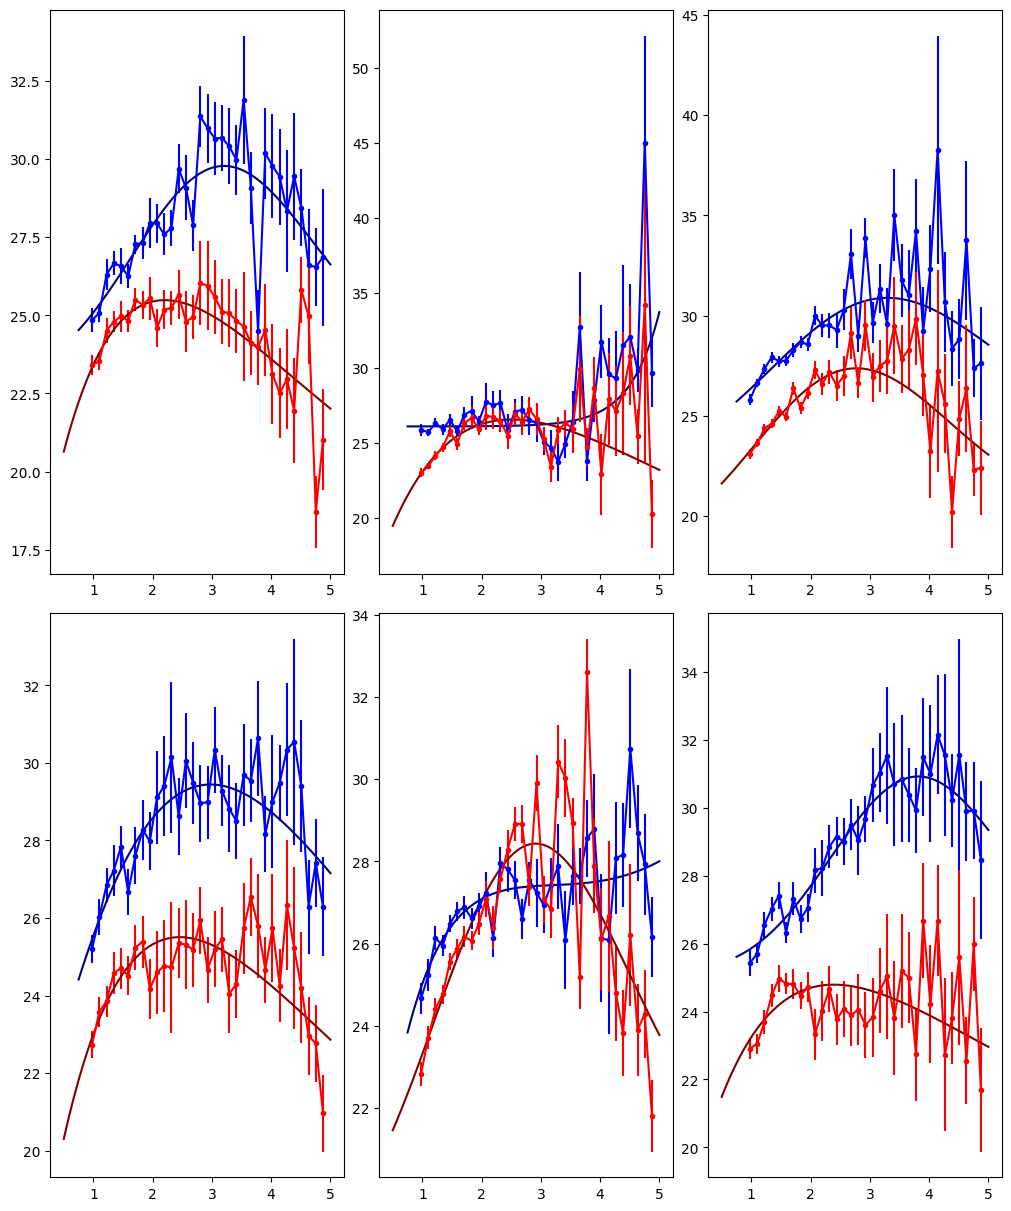

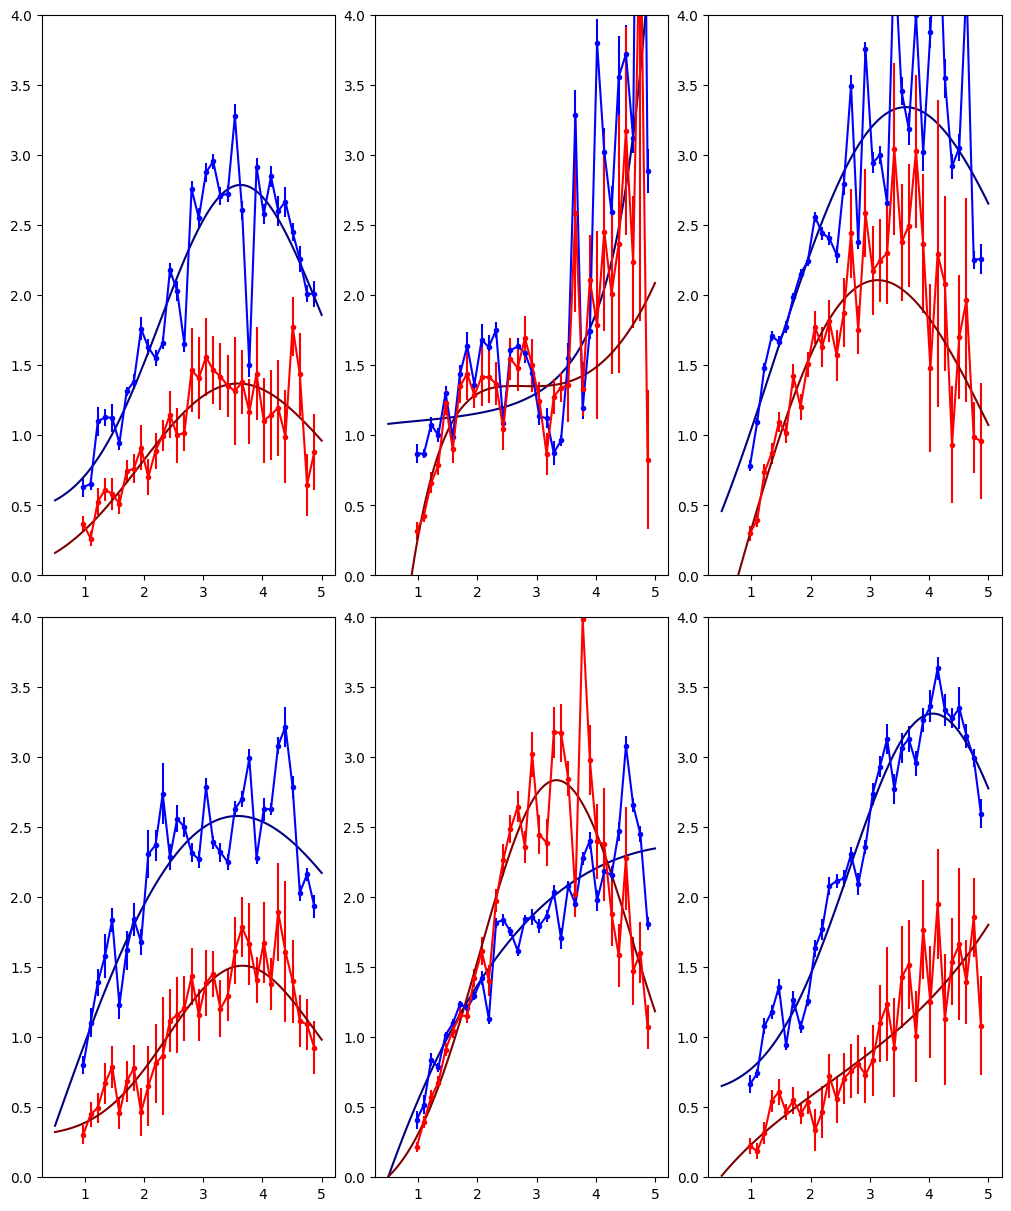

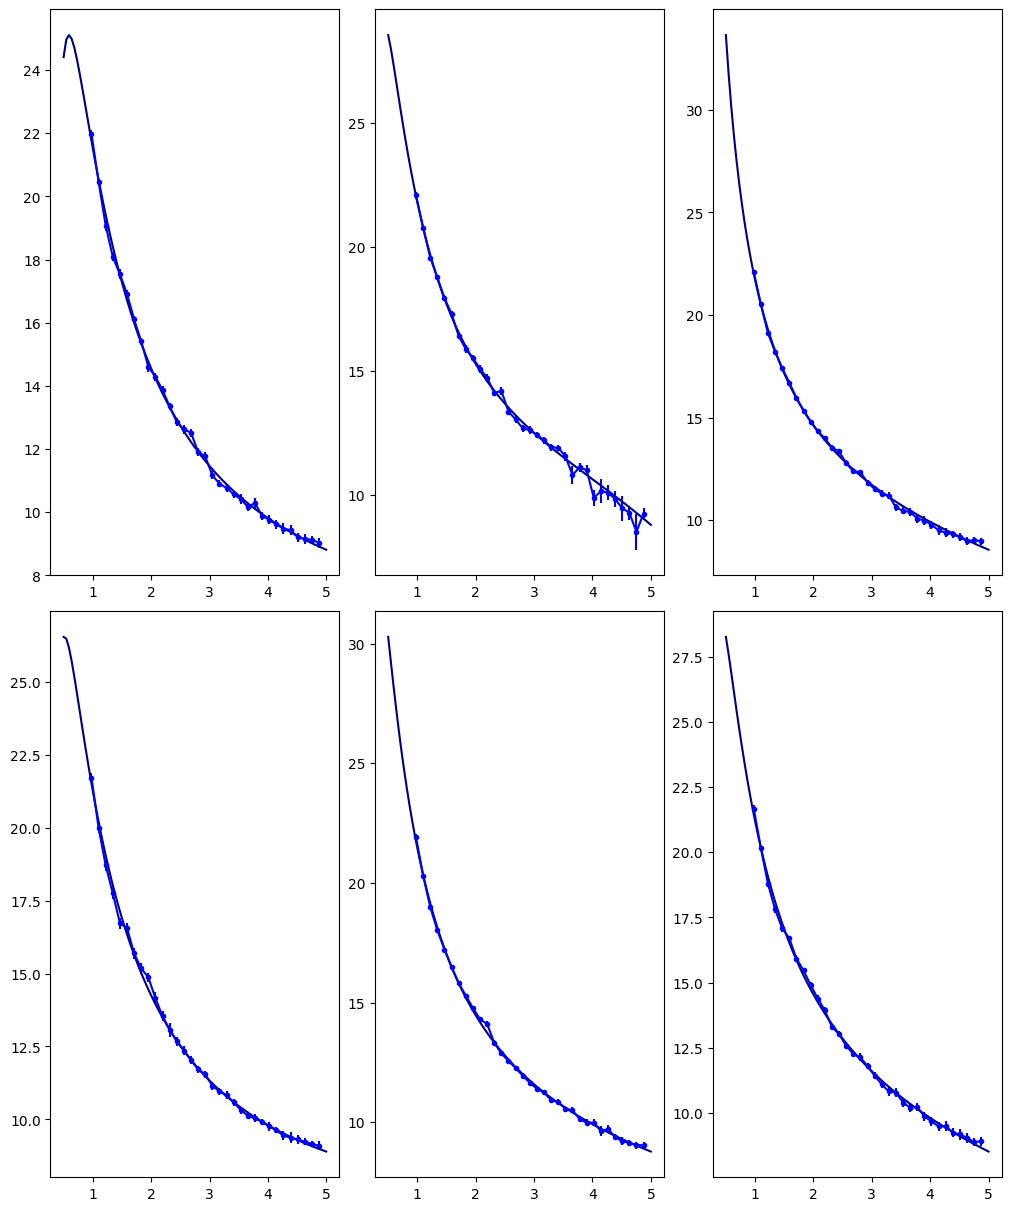

In [ ]:
pi_range = np.linspace(0 + (5)/40, 5 - 5/40, 40)[7:40]

pim_theta_min_params =[]
pim_params = [[] for i in range(4)]

fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')

p0=[
[22.69737102,  1.43862297, 53.72860297 , 4.76626883],
[ 25.22936743,  -0.58420767 ,198.03492013 ,  3],
[ 25.22936743,  -0.58420767 ,198.03492013 ,  1.34938381],
[26.84862117, -1.5683479,   2.46165834 , 1.95532219],
[26.15585521, -0.64291964, 18.286519,    1.96141262],
[ 25.22936743,  -0.58420767 ,198.03492013 ,  1.34938381]
]

p0=[
    [ 1.38734212e+01 , 1.58092717e+46 ,-3.75765050e-04, -5.25489581e+02],
    [ 1.38734212e+01 , 1.58092717e+46 ,-3.75765050e-04, -5.25489581e+02],
    [23.42833254 , 2.27471791, -0.17703057,  2.3239606 ],
    [ 1.38734212e+01 , 1.58092717e+46 ,-3.75765050e-04, -5.25489581e+02],
    [ 1.38734212e+01 , 1.58092717e+46 ,-3.75765050e-04, -5.25489581e+02],
    [26.1495786 , -2.37813622 , 1.41841281 , 1.35933975]
]

params_pim_l1 =  np.asarray(params_pim_l1)
params_pim_u1 =  np.asarray(params_pim_u1)

errs_pim_l1= np.asarray(errs_pim_l1)
errs_pim_u1= np.asarray(errs_pim_u1)

for i in range(0,6):
    extra_mask_u = (params_pim_u1[i][1:34]<100)&(errs_pim_u1[i][1:34]<100)
    extra_mask_l=  (params_pim_l1[i][1:34]<100)&(errs_pim_u1[i][1:34]<100)    

    ax[i%2, math.floor(i/2)].errorbar(pi_range[extra_mask_l], params_pim_l1[i][1:34][extra_mask_l], errs_pim_l1[i][1:34][extra_mask_l], marker = '.', linestyle='-', color='blue')
    popt_a, pcov_a = curve_fit(func_el_b, pi_range[extra_mask_l], 
                               params_pim_l1[i][1:34][extra_mask_l], 
                               sigma=errs_pim_l1[i][1:34][extra_mask_l], 
                               maxfev=1000000, 
                              p0=[25.24037743  ,1.61955564, -0.20310906  ,3.17053295])#p0[i])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.75, 5, 100), func_el_b(np.linspace(0.75, 5, 100), *popt_a), color='navy')
    pim_params[0].append(popt_a)
    print(popt_a)

    ax[i%2, math.floor(i/2)].errorbar(pi_range[extra_mask_u], params_pim_u1[i][1:34][extra_mask_u], errs_pim_u1[i][1:34][extra_mask_u], marker = '.', linestyle='-', color='red')
    popt_a, pcov_a = curve_fit(func_el_b, pi_range[extra_mask_u],
                                params_pim_u1[i][1:34][extra_mask_u], 
                                sigma=errs_pim_u1[i][1:34][extra_mask_u], 
                                maxfev=1500000, 
                                p0=[ 1.38734212e+01 , 1.58092717e+46 ,-3.75765050e-04, -5.25489581e+02])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.5, 5, 100), func_el_b(np.linspace(0.5, 5, 100), *popt_a), color='maroon')
    pim_params[1].append(popt_a)

fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')
params_pim_l2 =  np.asarray(params_pim_l2)
params_pim_u2 =  np.asarray(params_pim_u2)

errs_pim_l2= np.asarray(errs_pim_l2)
errs_pim_u2= np.asarray(errs_pim_u2)

p0=[
    [-0.02451813 , 1.16576816, -0.08641484 , 2.0009107 ],
    [-0.02451813 , 1.16576816, -0.08641484 , 2.0009107 ],
    [-0.29102886 , 0.38589699,  0.04423735 , 3.64579099 ],
    [-0.02451813 , 1.16576816, -0.08641484 , 2.0009107 ],
    [-0.02451813 , 1.16576816, -0.08641484 , 2.0009107 ],
    [-0.02451813 , 1.16576816, -0.08641484 , 2.0009107 ]
]

for i in range(0,6):
    extra_mask_u = (params_pim_u2[i][1:34]<1000)&(errs_pim_u2[i][1:34]<1000)
    extra_mask_l=  (params_pim_l2[i][1:34]<1000)&(errs_pim_l2[i][1:34]<1000)
    ax[i%2, math.floor(i/2)].errorbar(pi_range[extra_mask_l], params_pim_l2[i][1:34][extra_mask_l], errs_pim_l2[i][1:34][extra_mask_l], marker = '.', linestyle='-', color='blue')
    popt_b, pcov_b = curve_fit(func_pim_b, pi_range[extra_mask_l], 
                               params_pim_l2[i][1:34][extra_mask_l], 
                               sigma=errs_pim_l2[i][1:34][extra_mask_l], 
                               maxfev=1500000,
                               p0=[-0.02451813 , 1.16576816, -0.08641484 , 2.0009107 ])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.5, 5, 100), func_pim_b(np.linspace(0.5, 5, 100), *popt_b), color='navy')
    pim_params[2].append(popt_b)
  
    ax[i%2, math.floor(i/2)].errorbar(pi_range[extra_mask_u], params_pim_u2[i][1:34][extra_mask_u], errs_pim_u2[i][1:34][extra_mask_u], marker = '.', linestyle='-', color='red')
    popt_b, pcov_b = curve_fit(func_pim_b, pi_range[extra_mask_u], 
                               params_pim_u2[i][1:34][extra_mask_u], 
                               sigma=errs_pim_u2[i][1:34][extra_mask_u], 
                               maxfev=1500000,
                               p0=p0[i])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.5, 5, 100), func_pim_b(np.linspace(0.5, 5, 100), *popt_b), color='maroon')
    ax[i%2, math.floor(i/2)].set_ylim(0,4)
    pim_params[3].append(popt_b)
  

fig, ax = plt.subplots(2, 3, figsize=(10,12), layout='constrained')

for i in range(0,6):
    
    ax[i%2, math.floor(i/2)].errorbar(pi_range, params_pim_l3[i][1:34], errs_pim_l3[i][1:34], marker = '.', linestyle='-', color='blue')

    popt_t, pcov_t = curve_fit(func_theta_min_el, pi_range, params_pim_l3[i][1:34], sigma=errs_pim_l3[i][1:34], maxfev=2500000, p0=[-2.90707390e+00, -2.00636024e+01 , 1.47550799e+00 , 4.10308689e+01,
 -3.01837933e-02 , 8.87328903e-01])
    ax[i%2, math.floor(i/2)].plot(np.linspace(0.5, 5, 100), func_theta_min_el(np.linspace(0.5, 5, 100), *popt_t), color='navy')
    pim_theta_min_params.append(popt_t)


In [ ]:
parIdx = [0,1,2]

max_par = [[[] for sec in range(6)] for par in range(3)]
mean_par = [[[] for sec in range(6)] for par in range(3)]

p_pi = np.linspace(0,5,40)[8:40]
p_e = np.linspace(3, 8,40)[0:32]



for i in parIdx:
    side = 1
    phi_avg =0
    theta_min_fixed = 0

    p_low = 0 if i == 0 else 8
    p_high = 32 if i == 0 else 40
    Range = range(p_low, p_high)


    for sector in [0,1,2,3,4,5]:
        max_array = []
        mean_array = []
        for p in Range:

            y_mean, x_mean, max_theta = getHistMean(i, p, sector)        

            max_array.append(max_theta)
            mean_array.append(x_mean)
            
        #ax[sector%2, math.floor(sector/2)].plot(p_e if i == 0 else p_pi, max_par[i][sector], marker='o', linestyle='-')
        popt_theta, _ = curve_fit(poly3, p_e if i == 0 else p_pi, max_array)
        popt_mean, _ = curve_fit(poly3, p_e if i == 0 else p_pi, mean_array)
        
        #ax[sector%2, math.floor(sector/2)].plot(np.linspace(0, 5, 100), poly3(np.linspace(0, 5, 100), *popt_theta), marker = ' ', linestyle='-')
        #if i ==0:
        #    print(popt_theta)
        max_par[i][sector].append(popt_theta)
        mean_par[i][sector].append(popt_mean)


[[array([25.97006531, -8.69523784,  1.22979315, -0.06382105])], [array([ 8.57255459e+01, -8.15442783e+00,  1.10219090e+00, -5.49848443e-02])], [array([ 1.45153184e+02, -7.94429453e+00,  1.07924236e+00, -5.39564101e-02])], [array([ 2.05243095e+02, -8.13638976e+00,  1.11379223e+00, -5.60339265e-02])], [array([-9.52523749e+01, -7.95474104e+00,  1.07190236e+00, -5.30360144e-02])], [array([-34.46296519,  -8.14051503,   1.11606263,  -0.05623347])]]


/var/folders/4d/9x90517x6q3cc4_sz1jrqlj00000gn/T/ipykernel_37892/3421880798.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(10,12), layout='constrained')


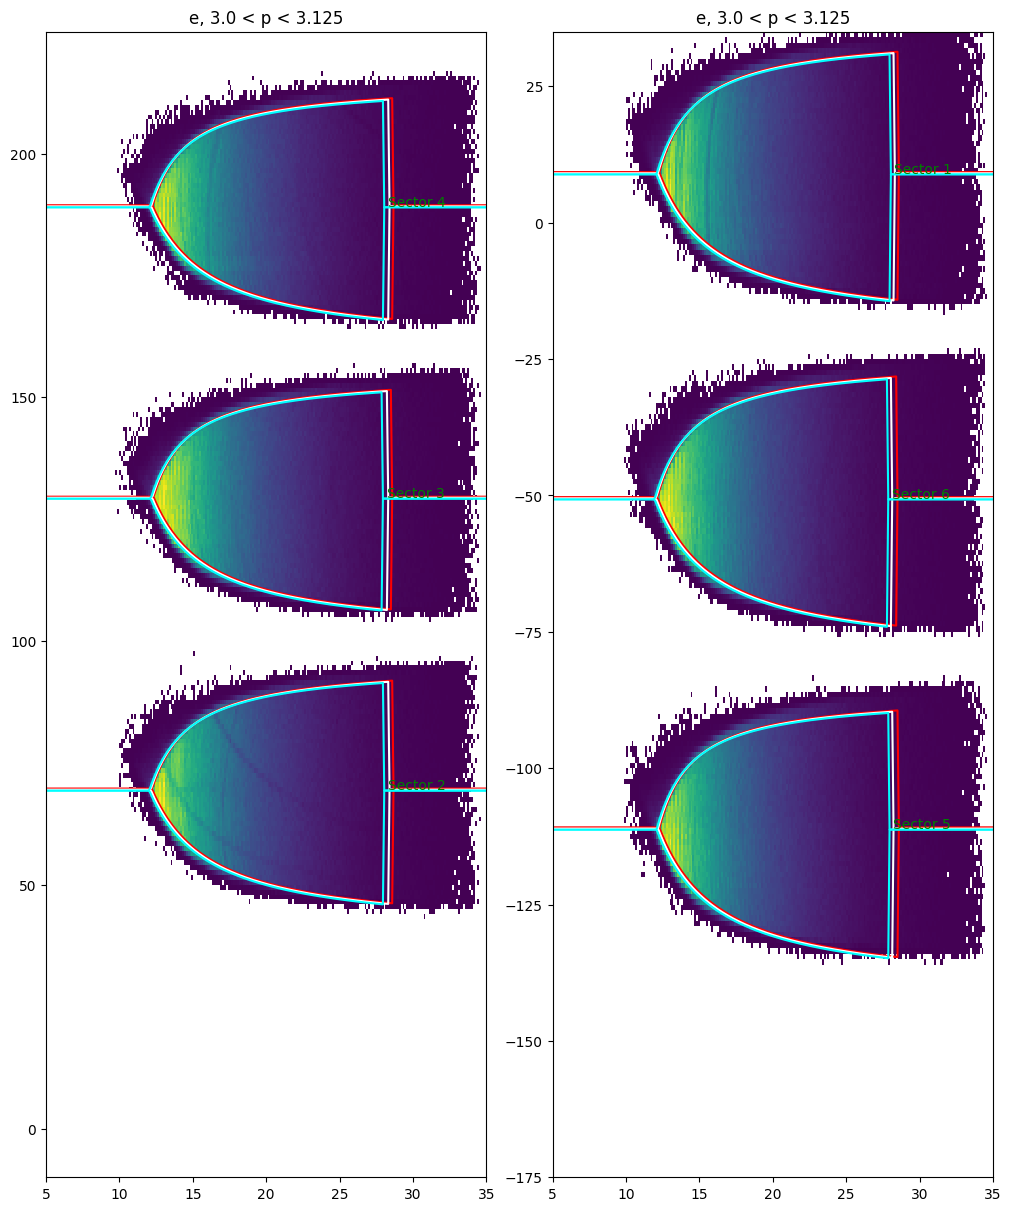

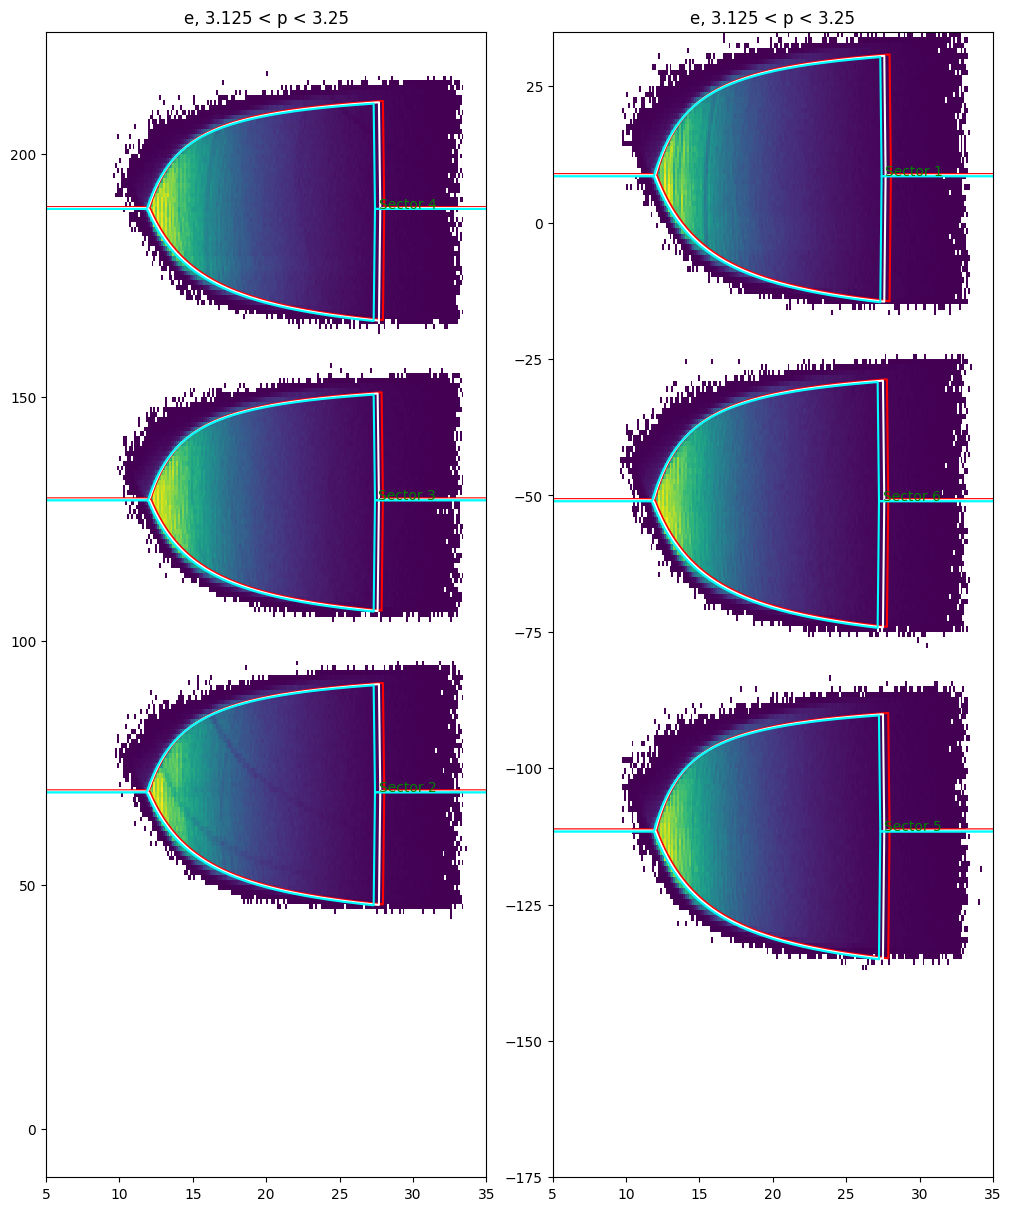

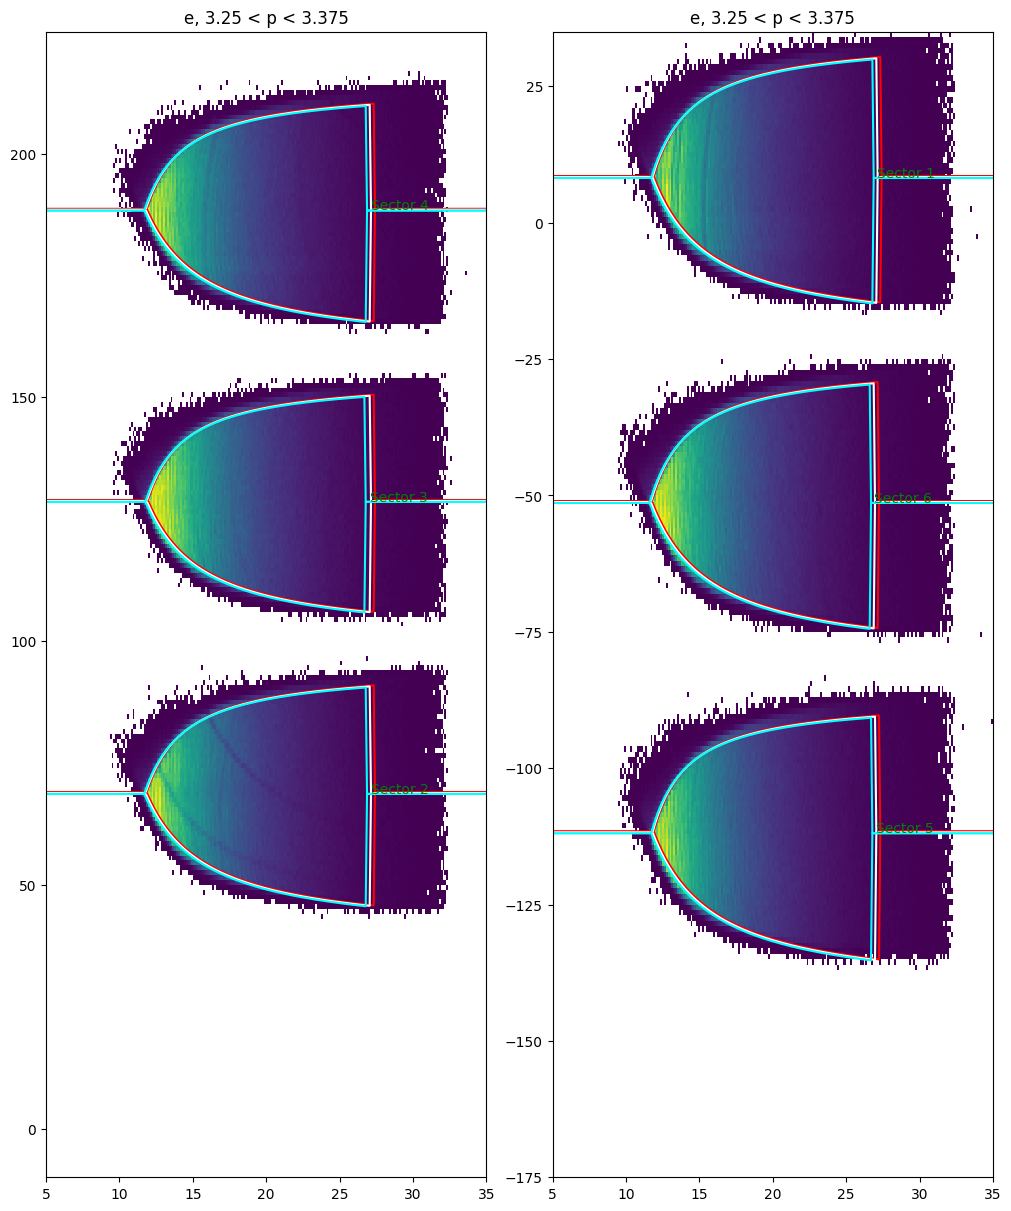

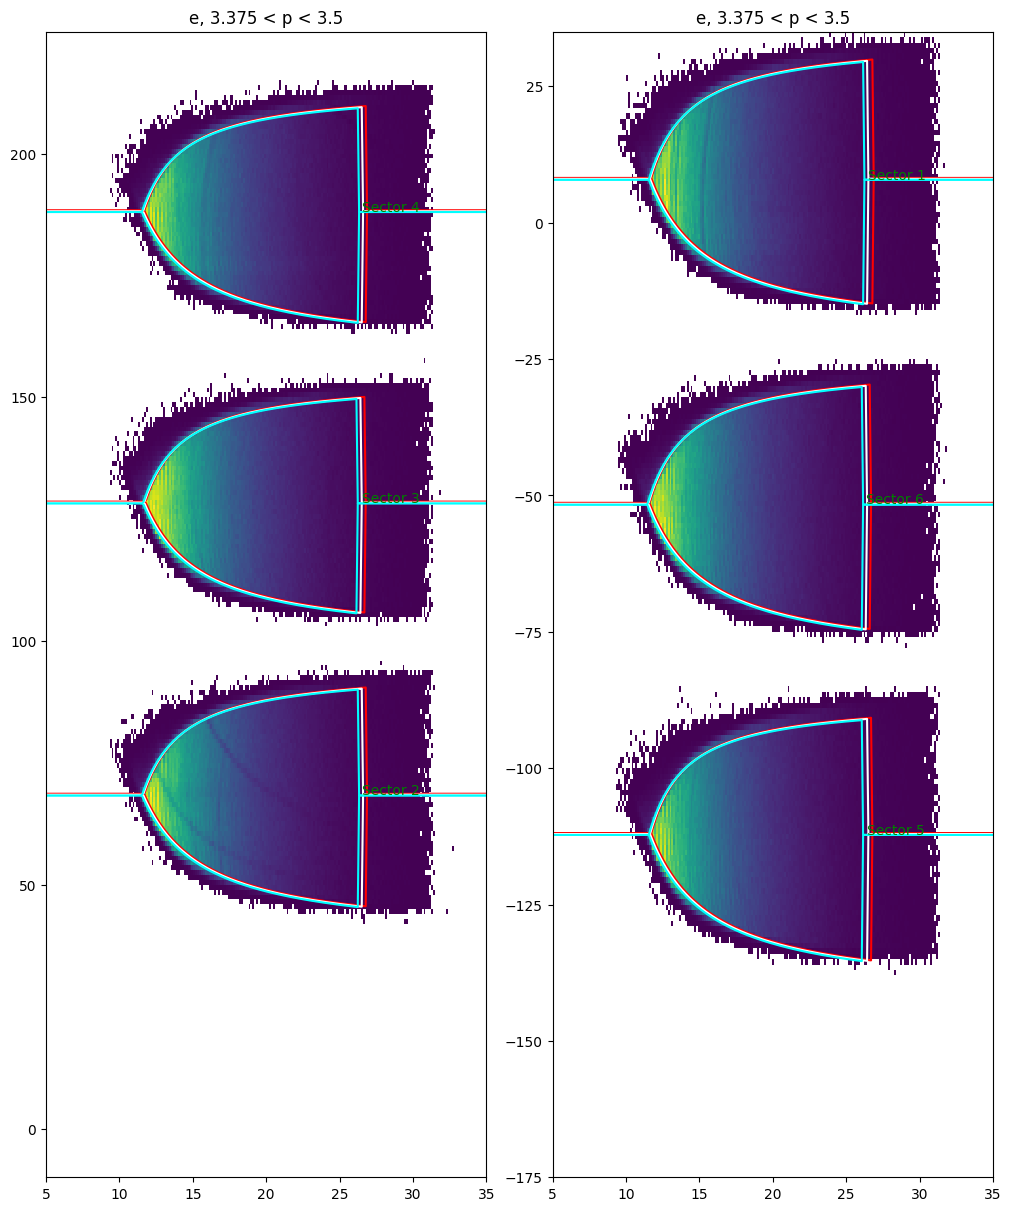

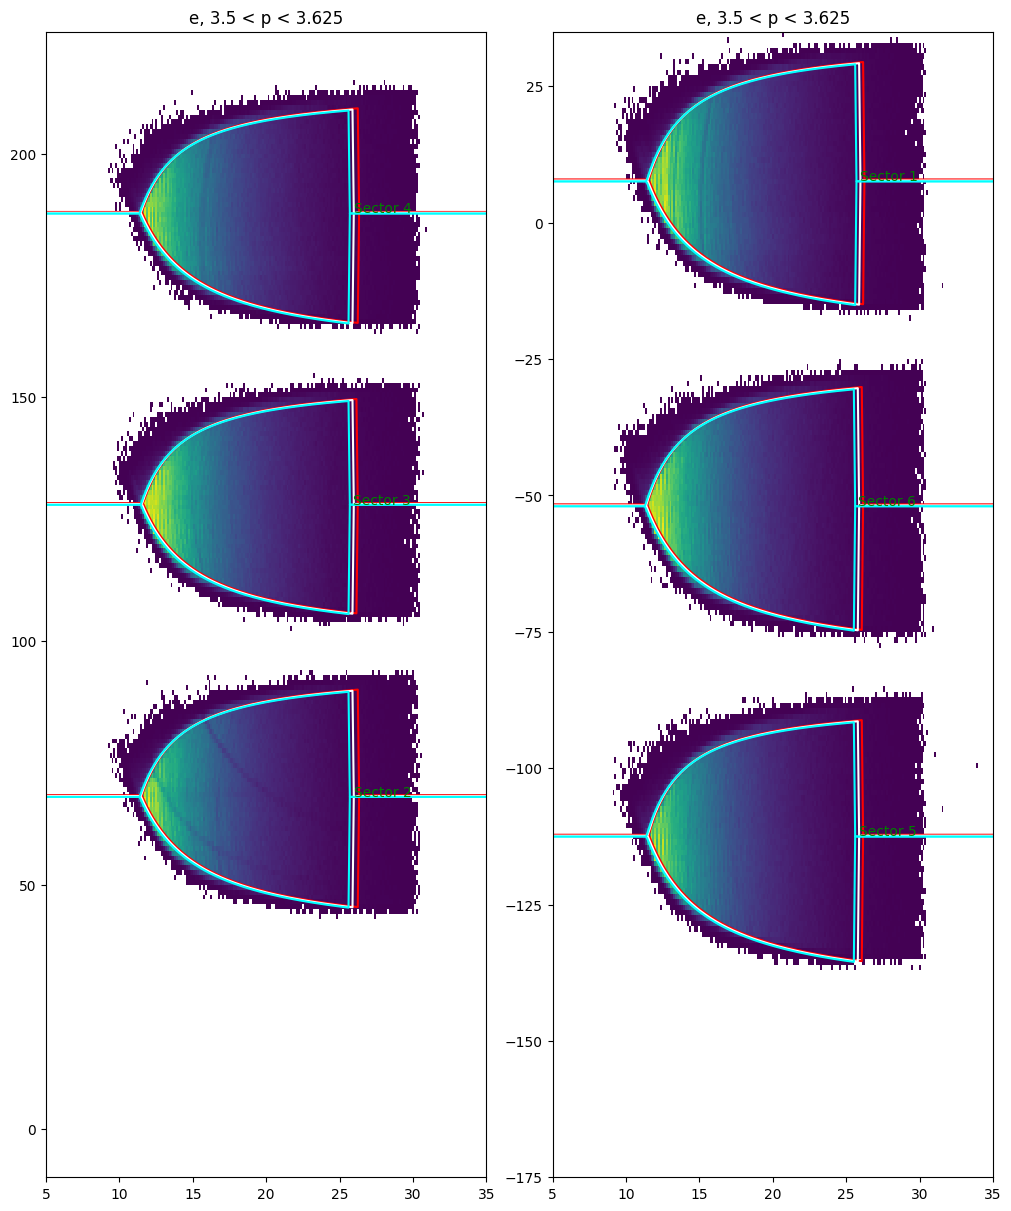

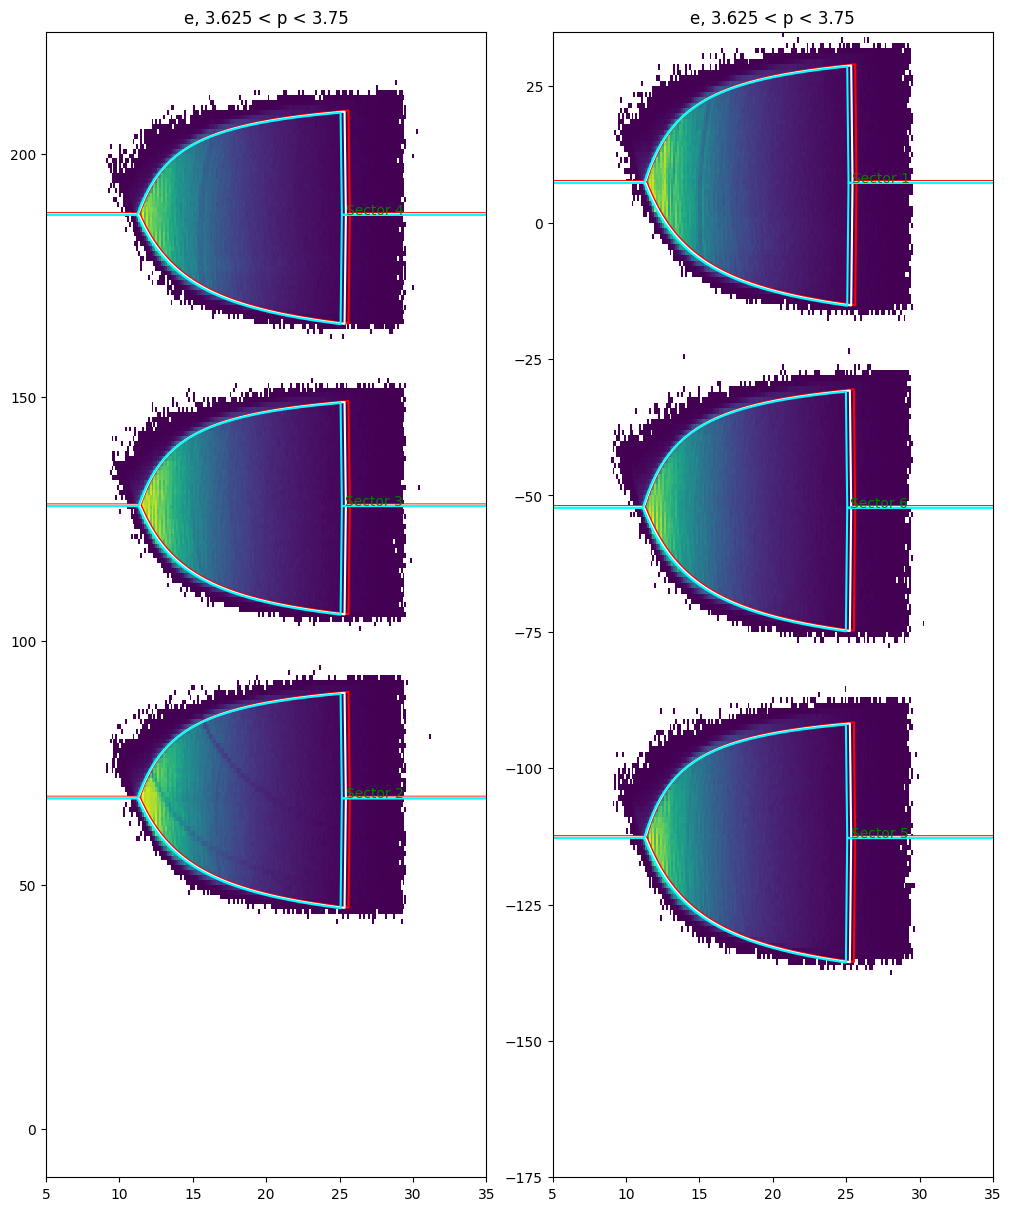

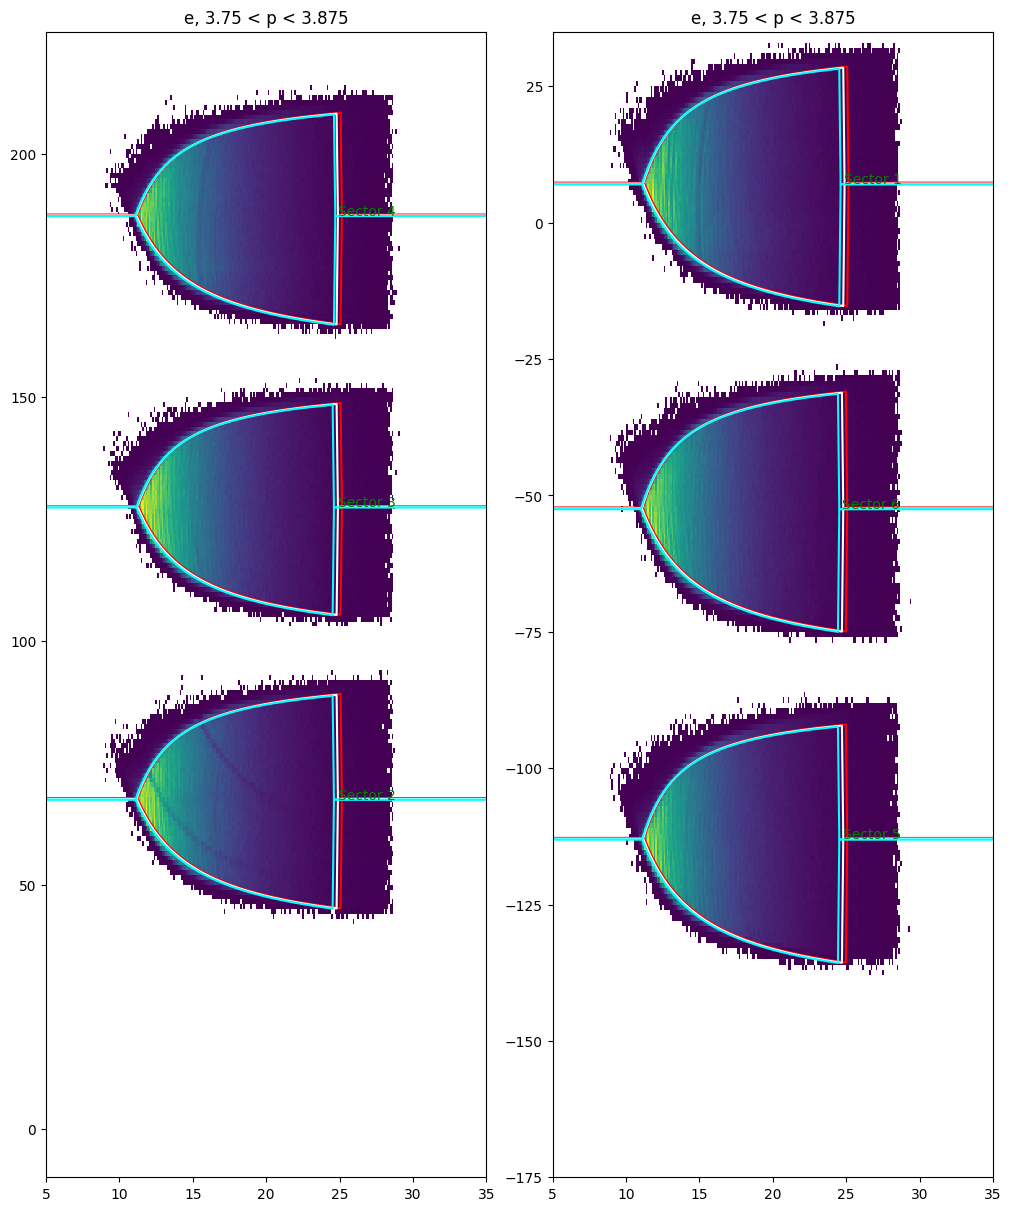

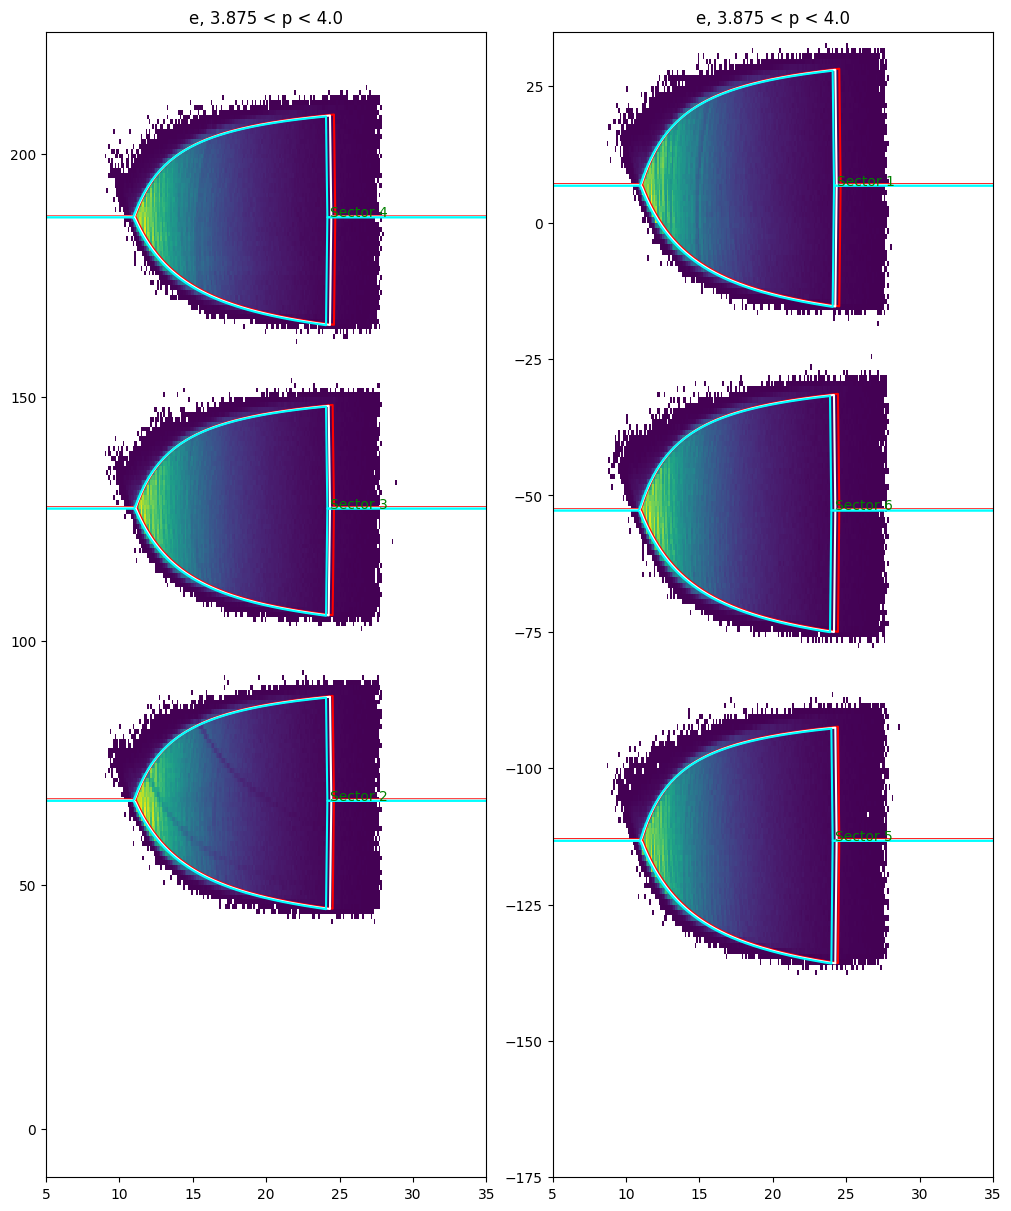

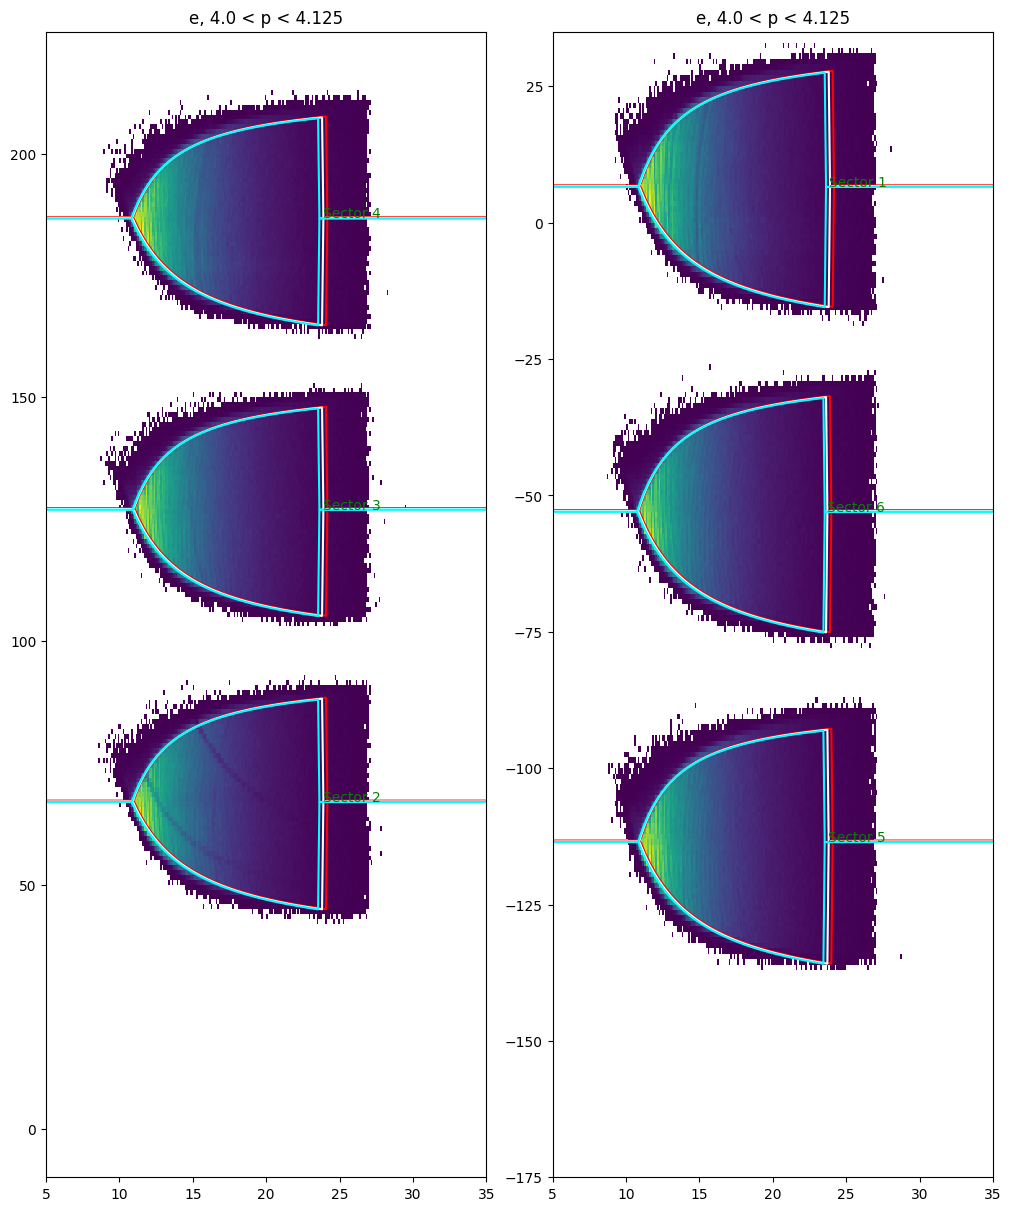

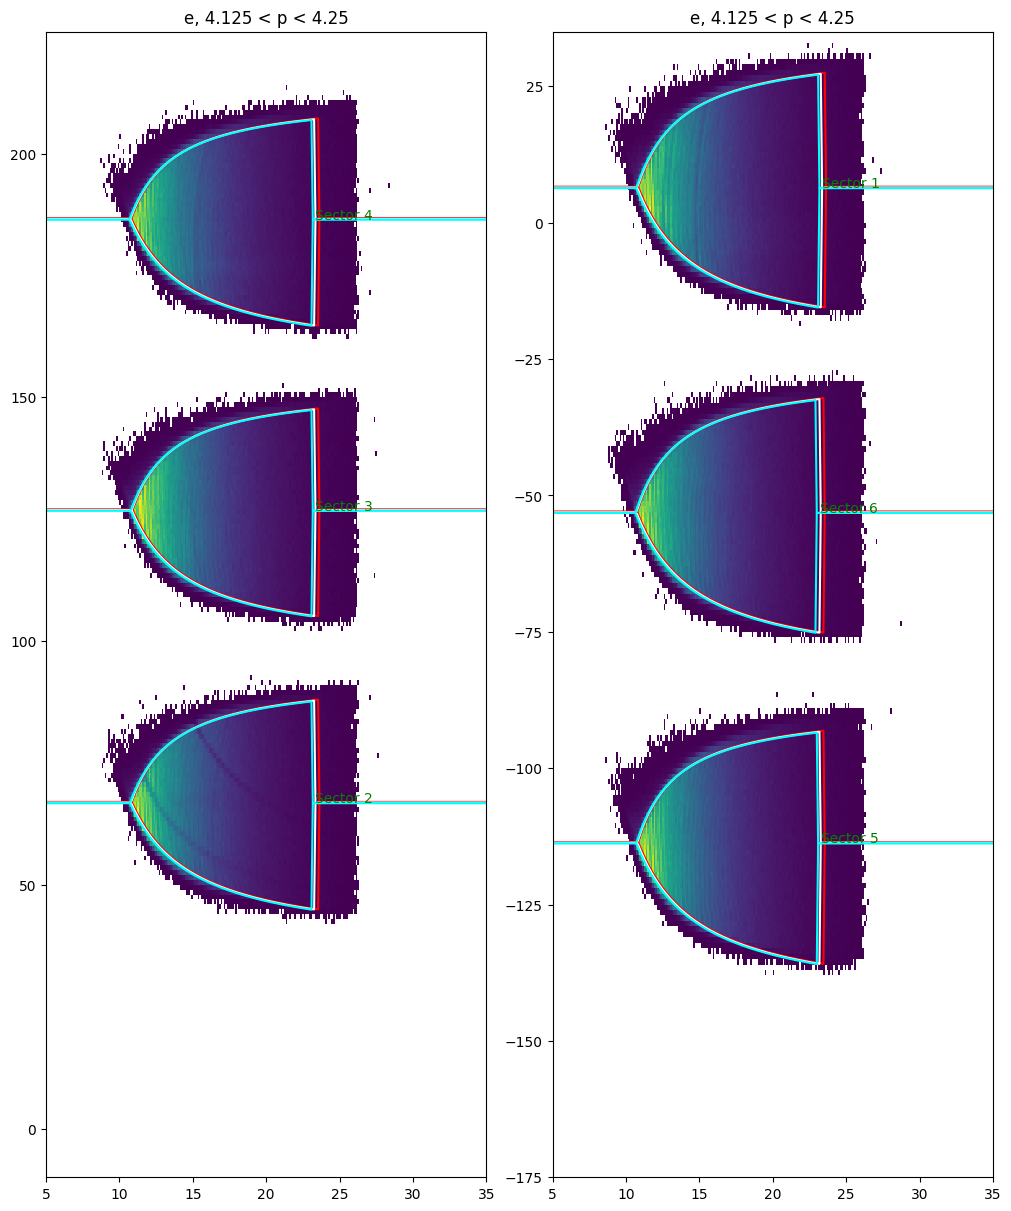

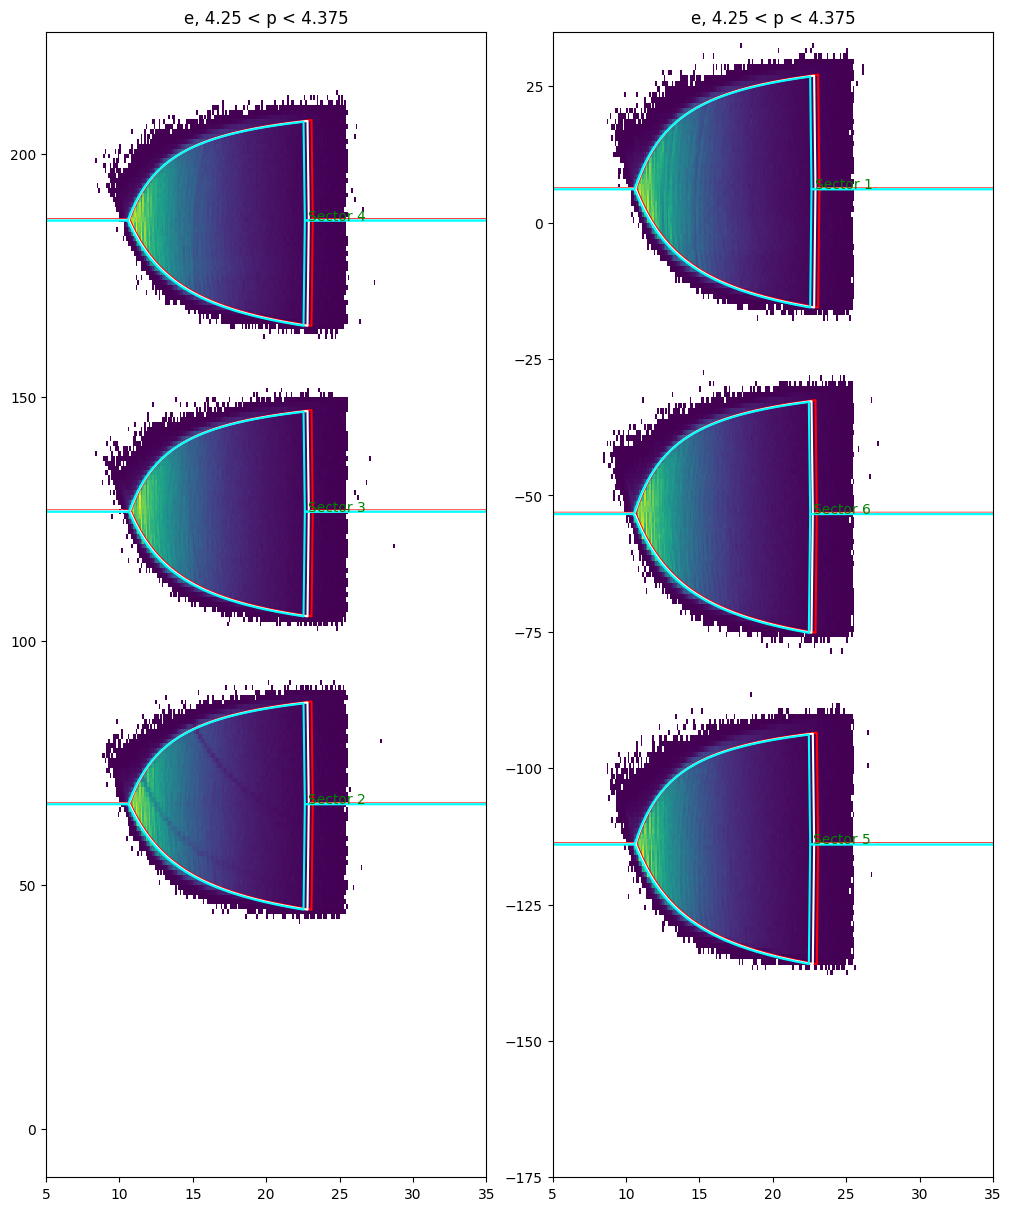

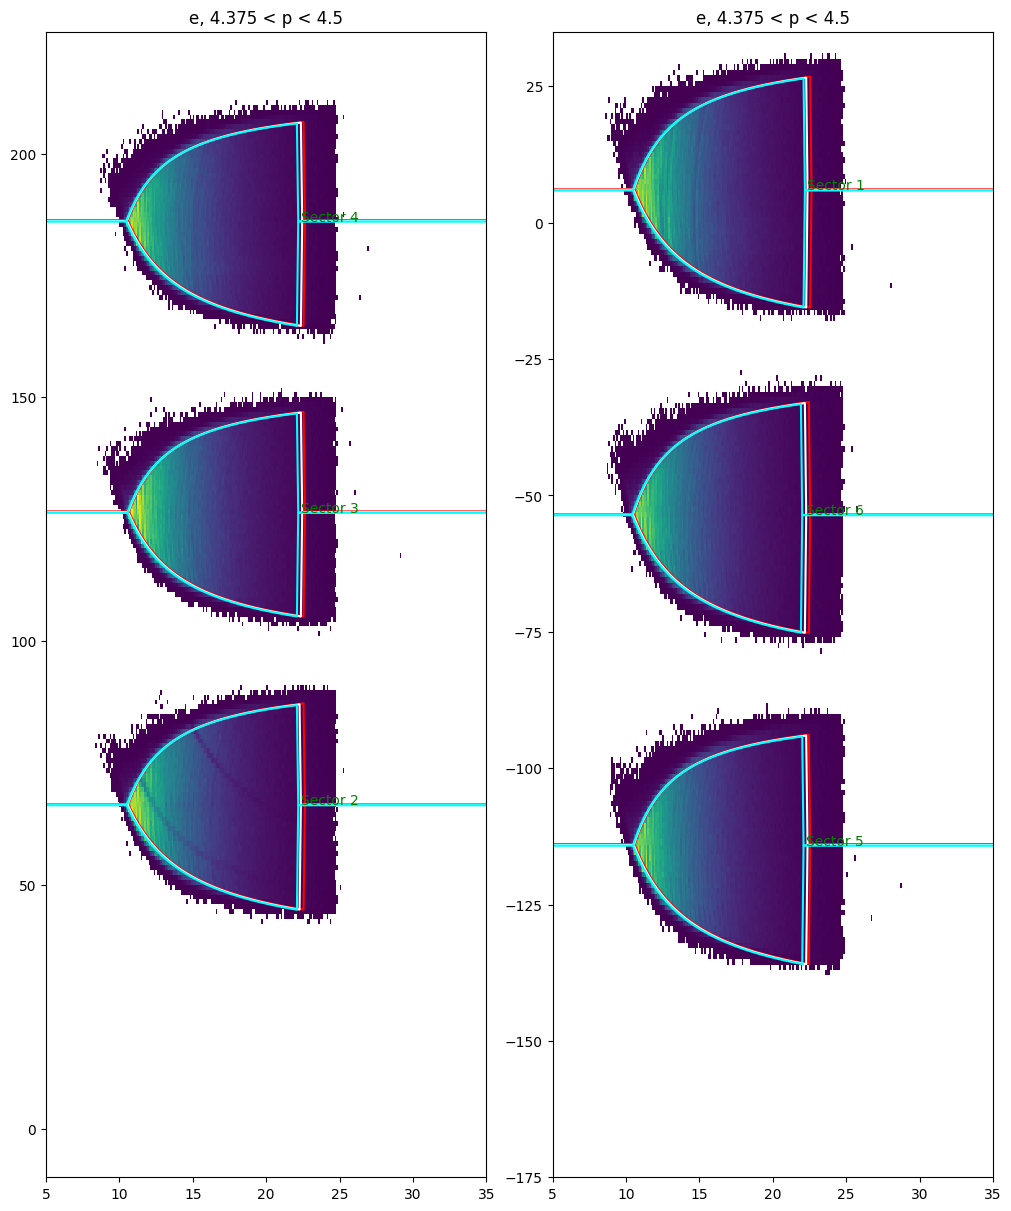

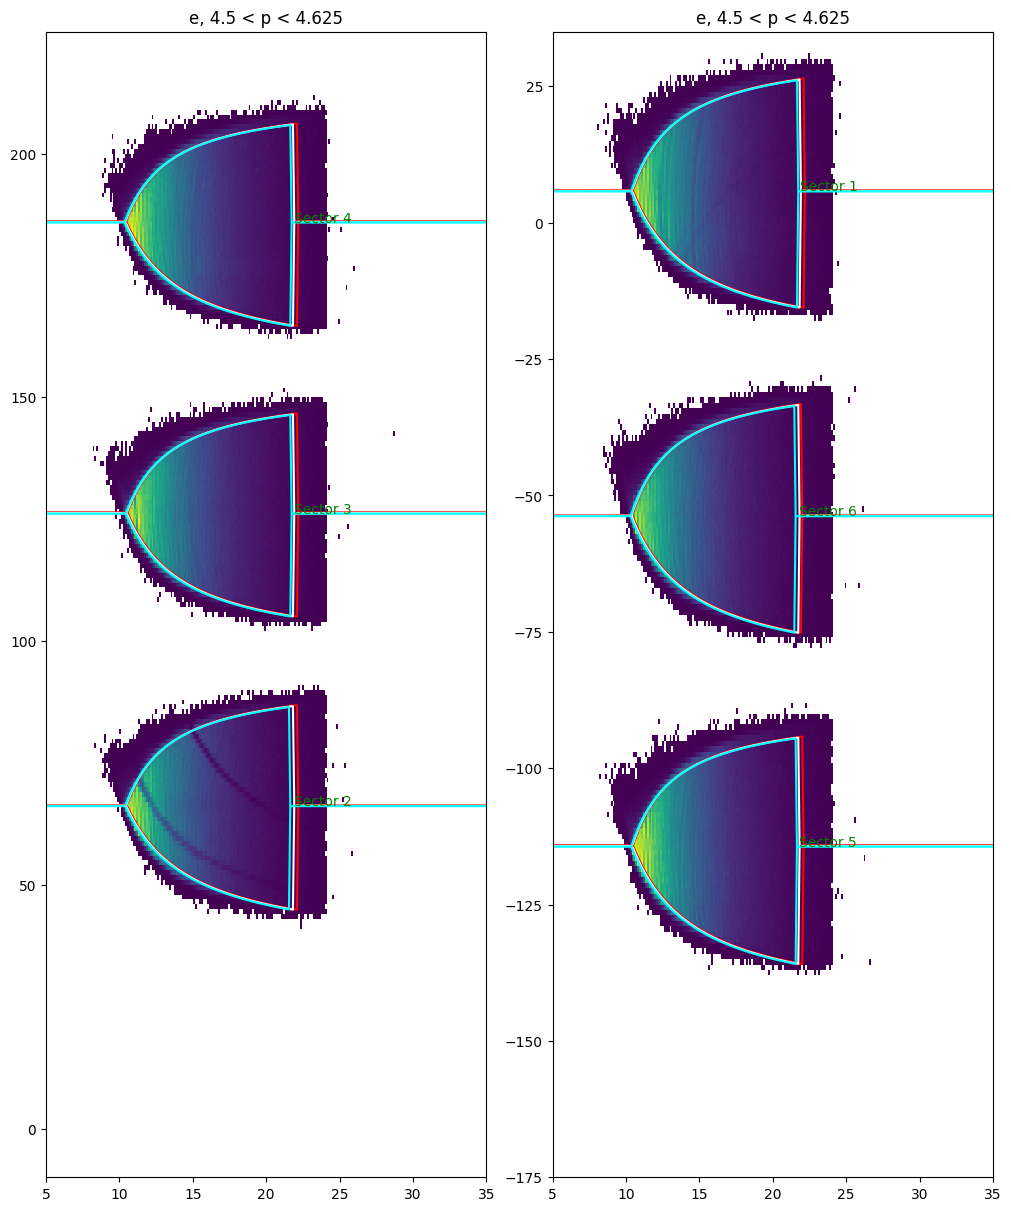

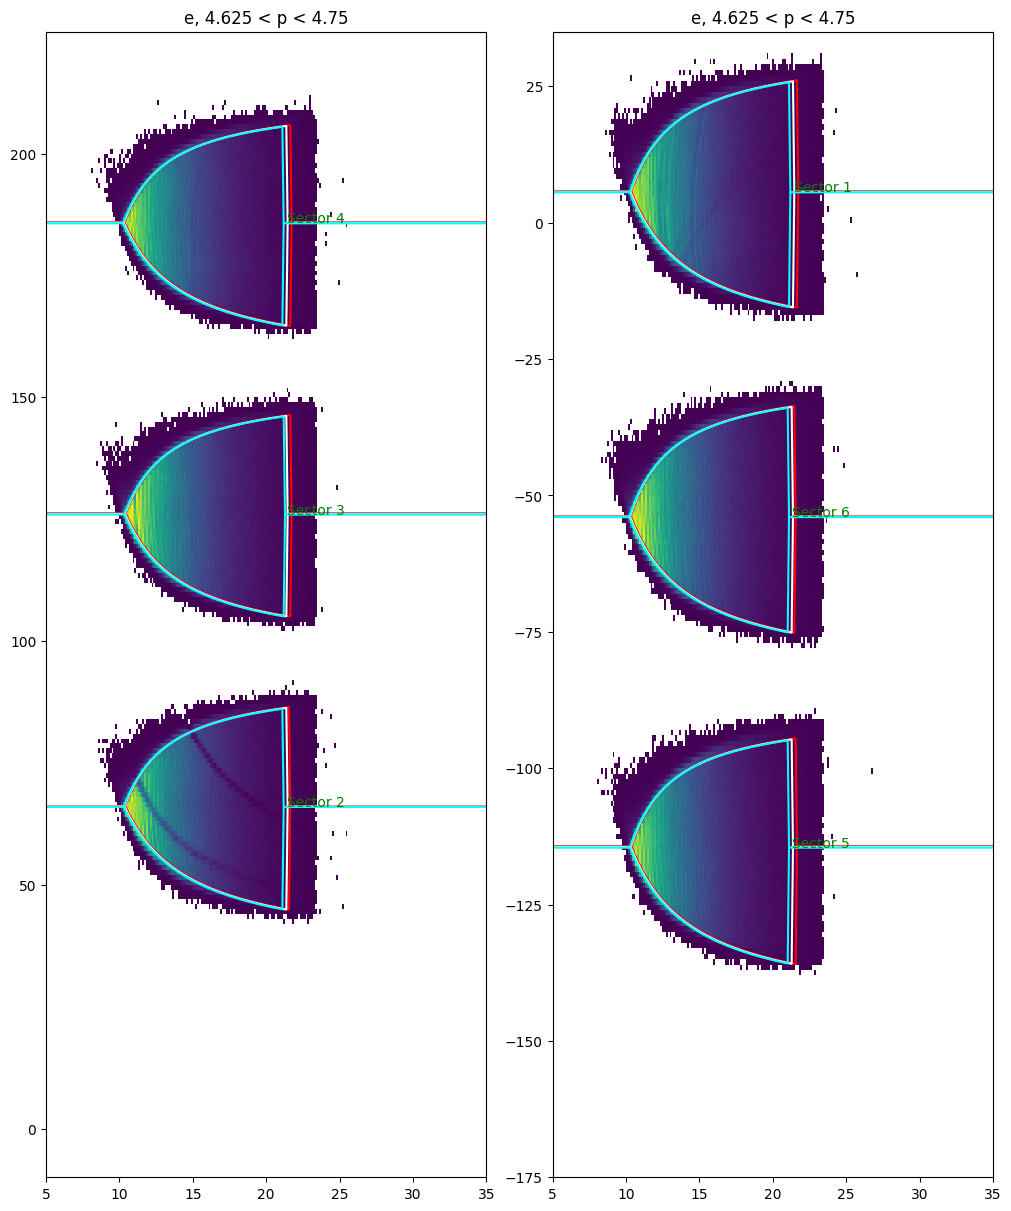

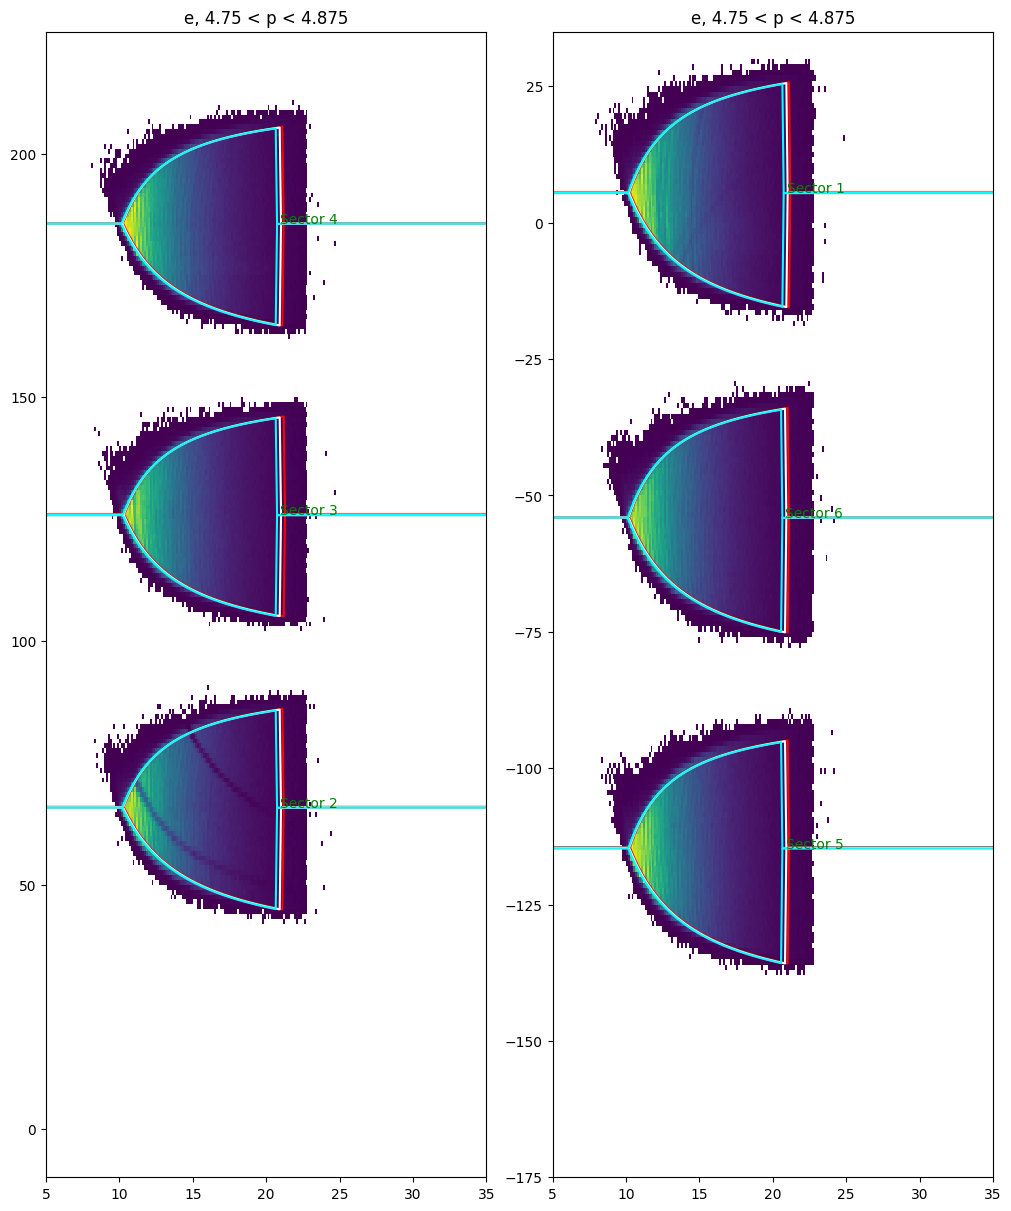

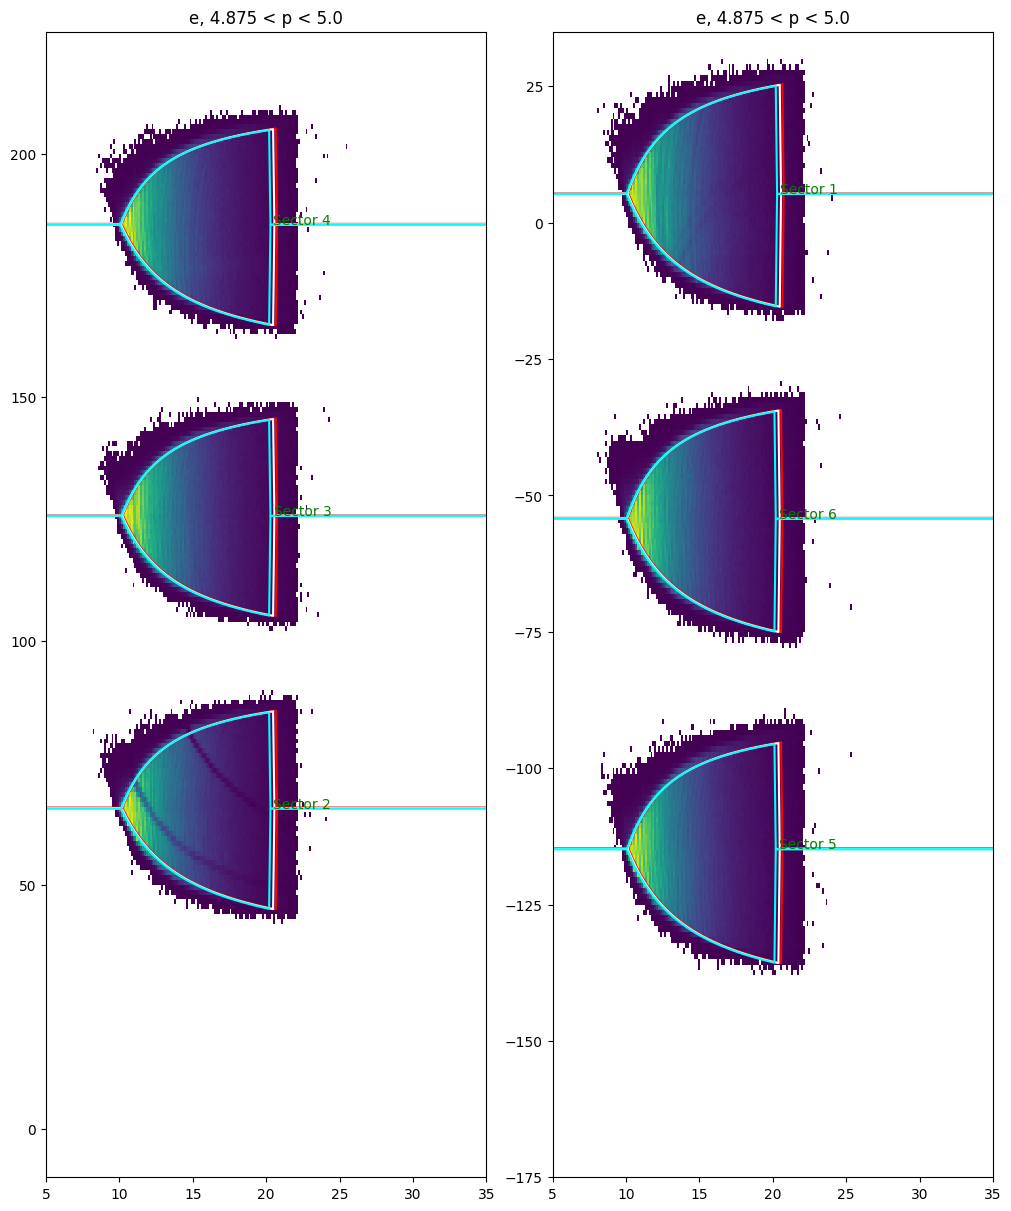

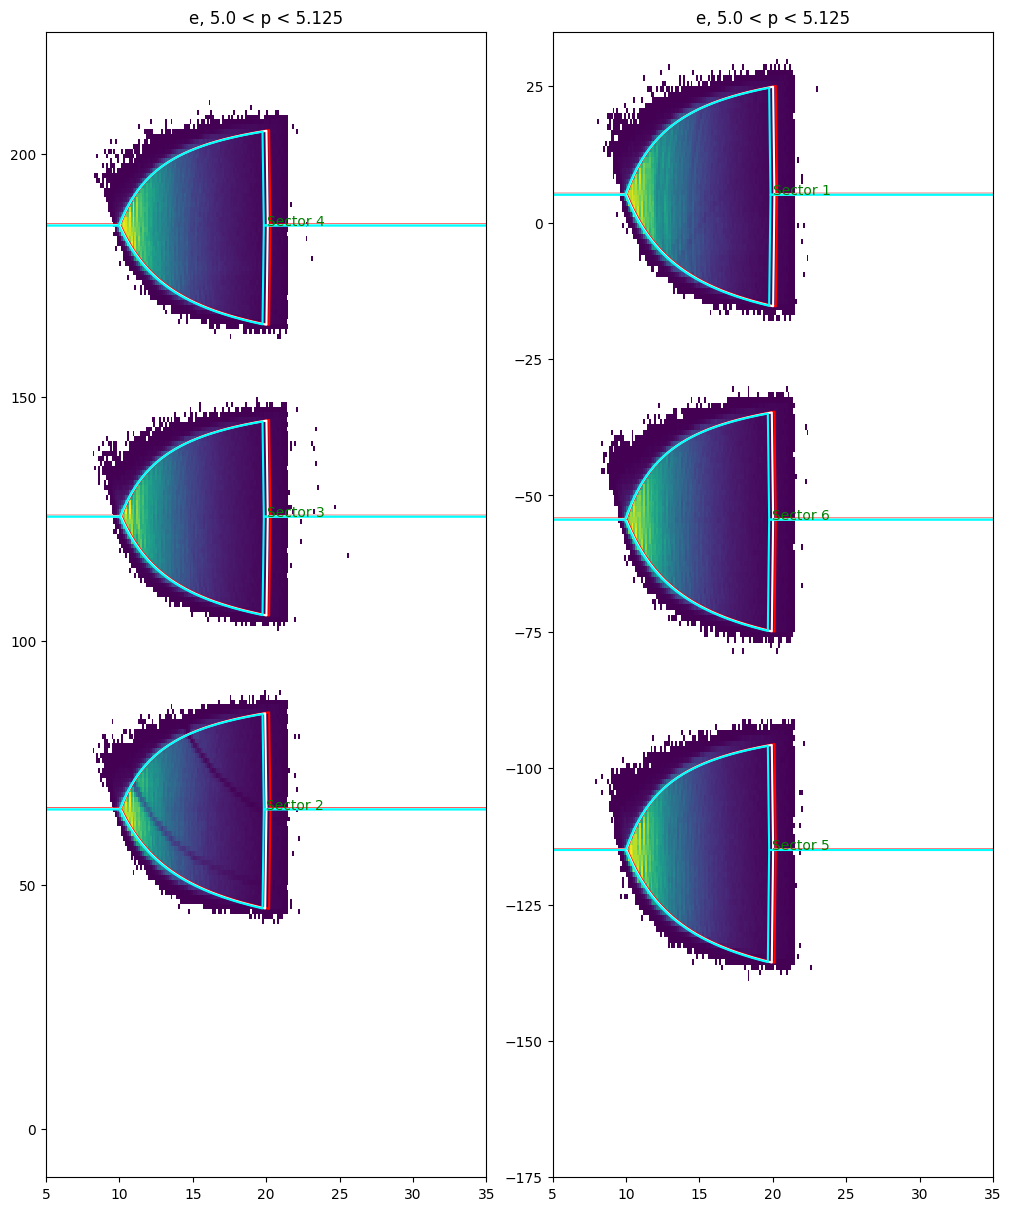

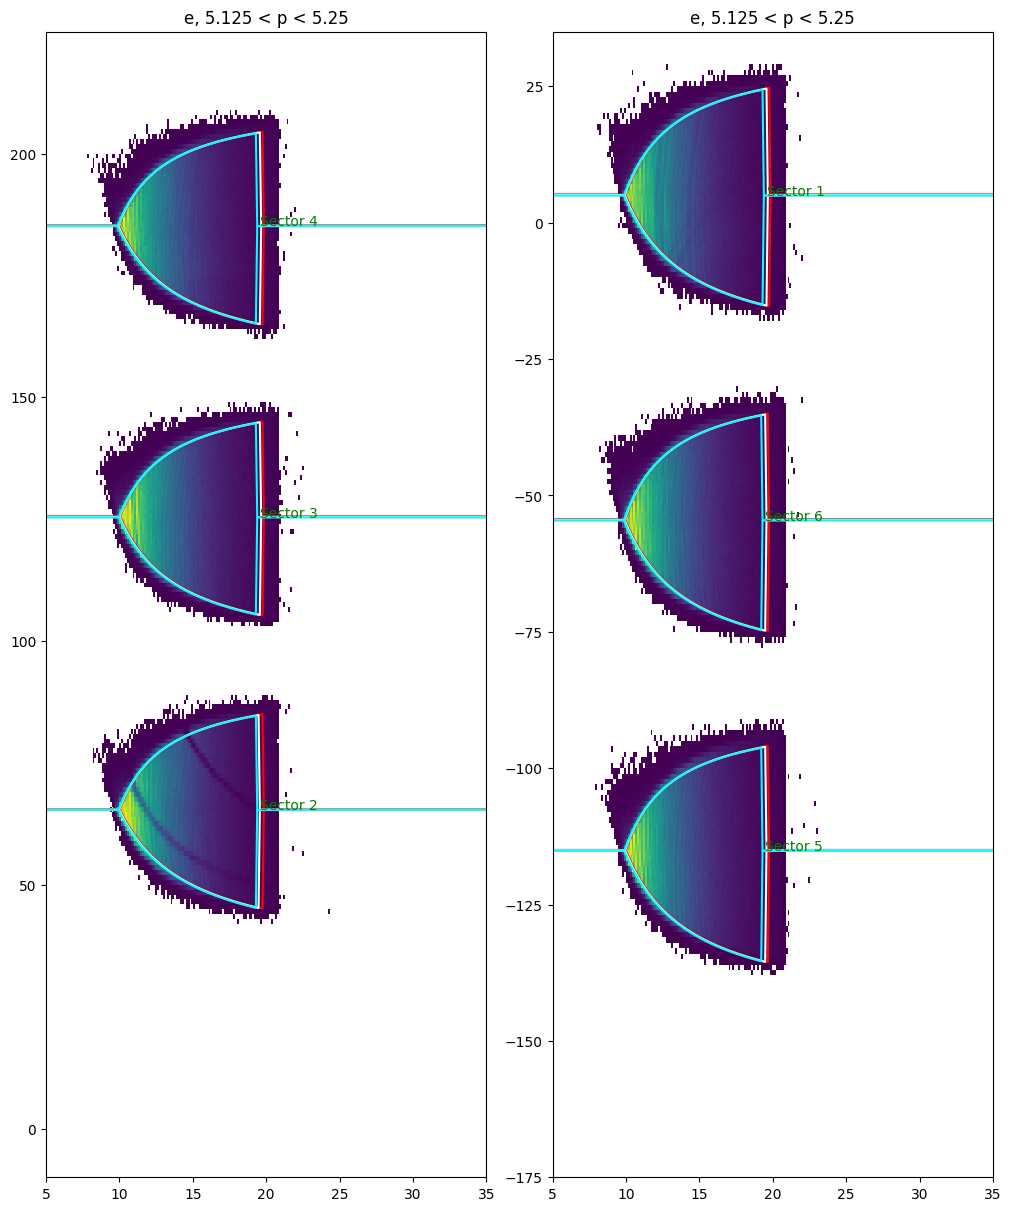

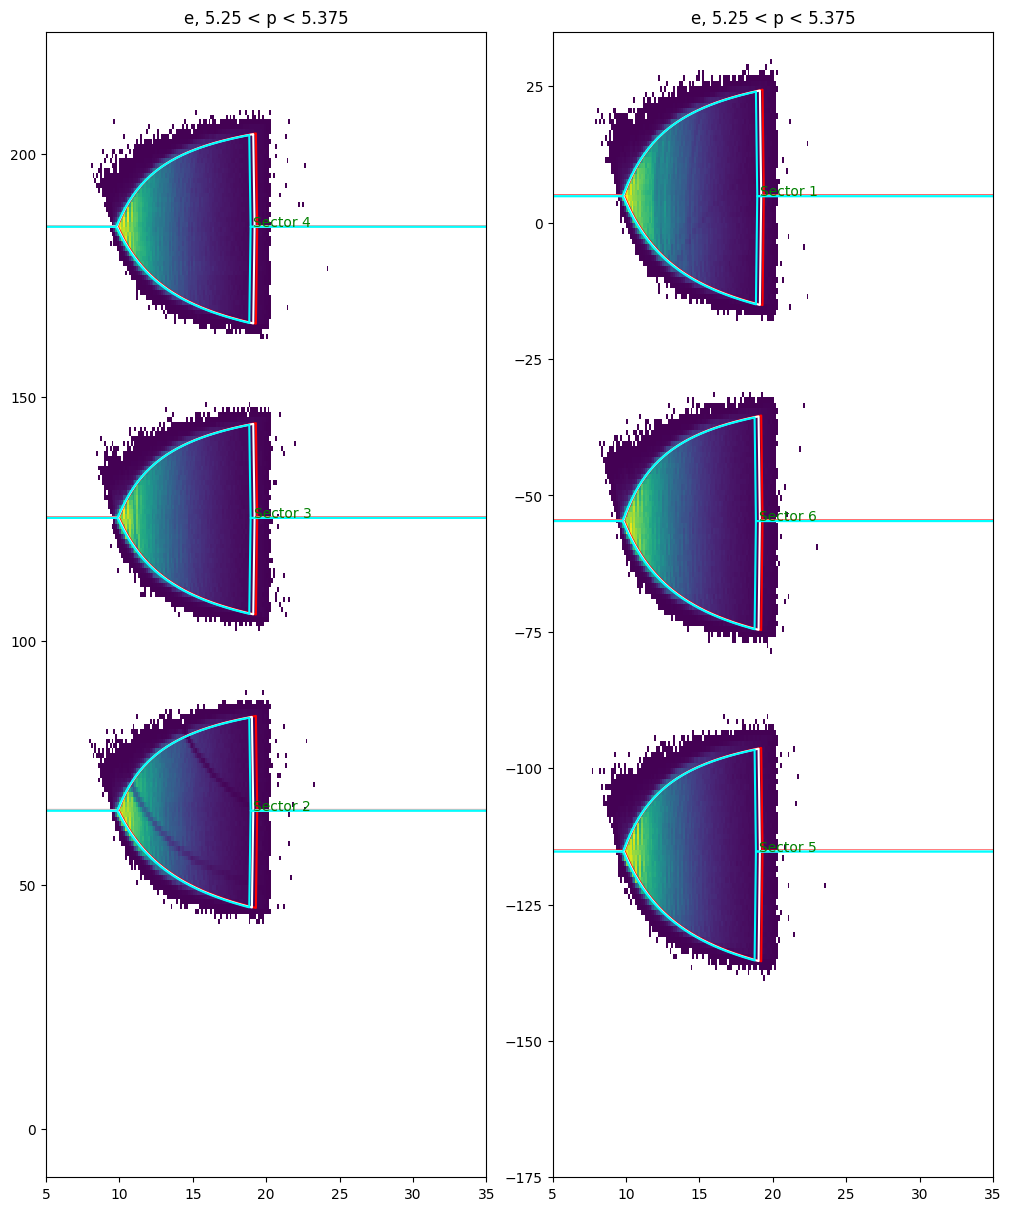

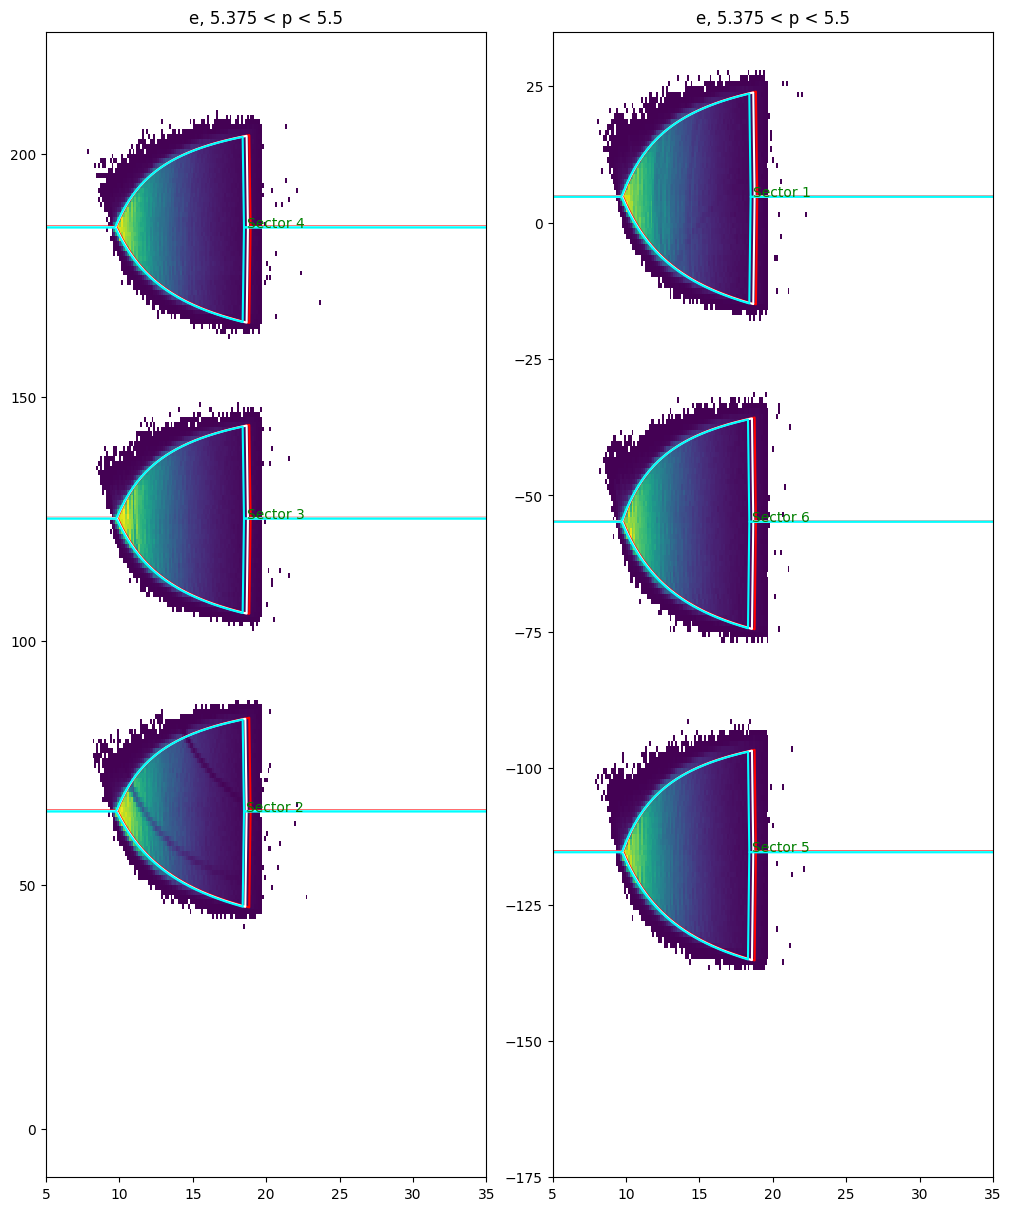

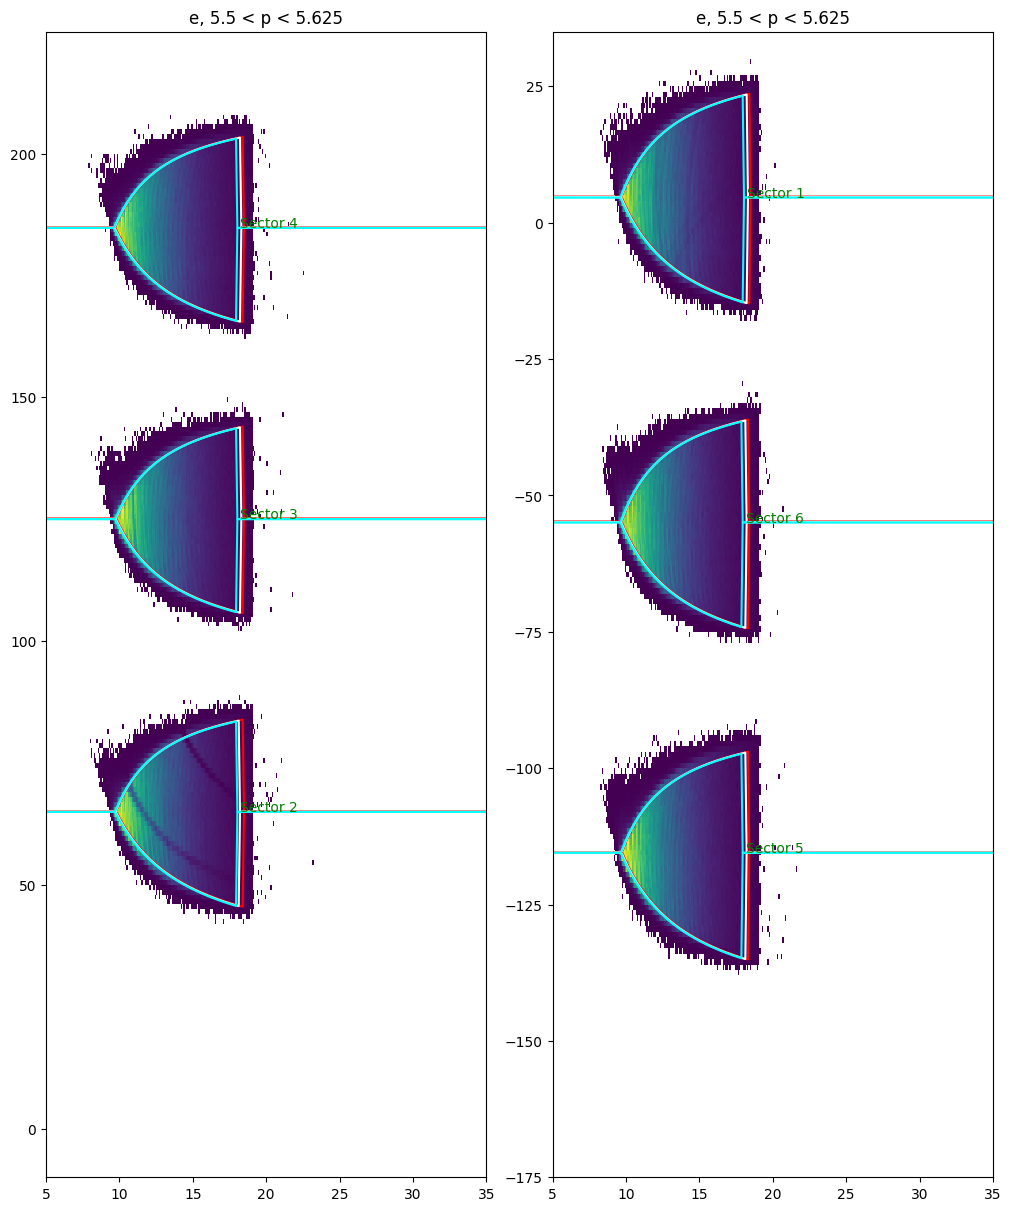

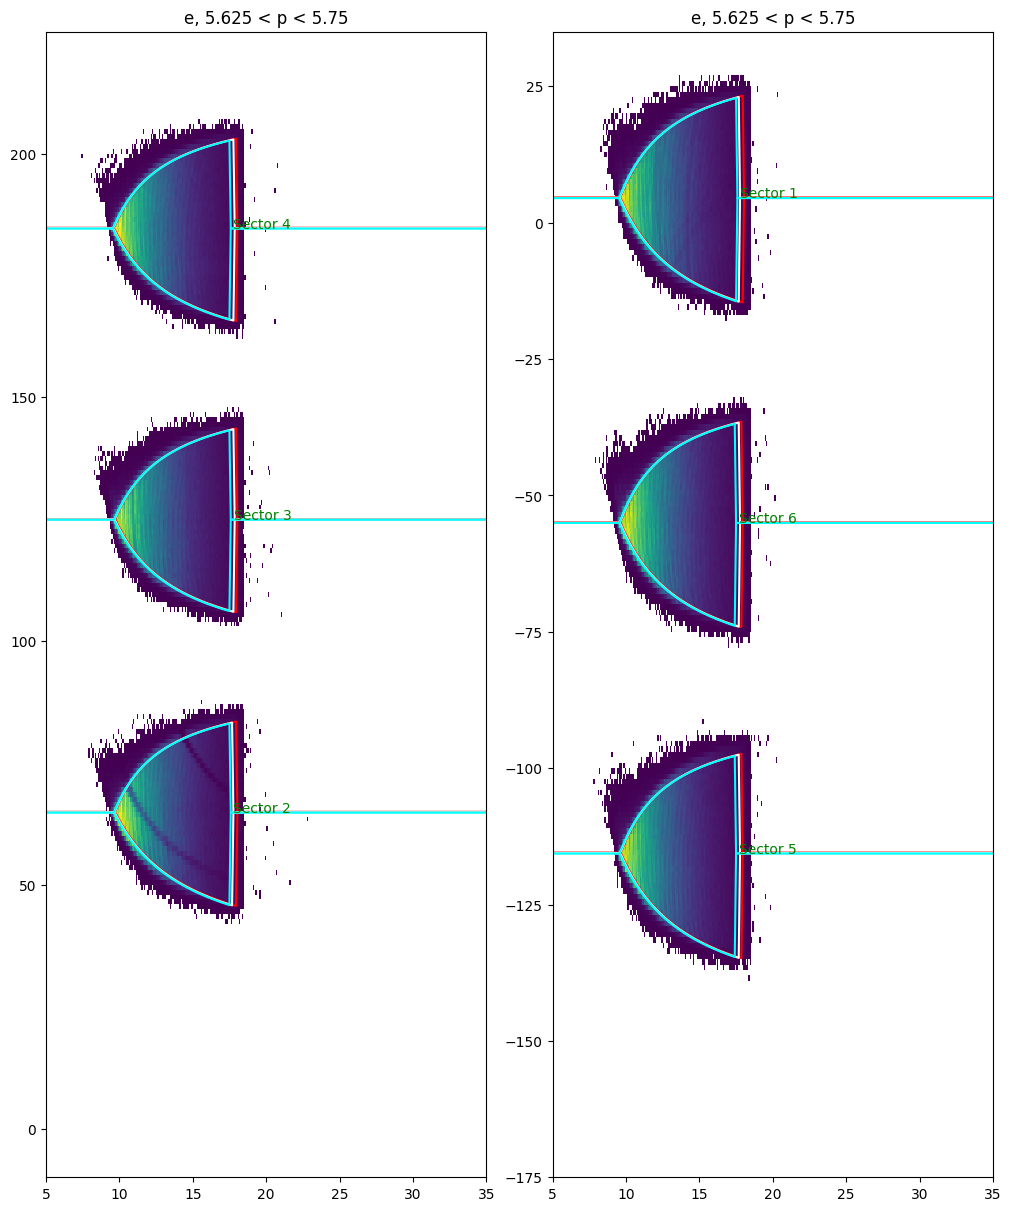

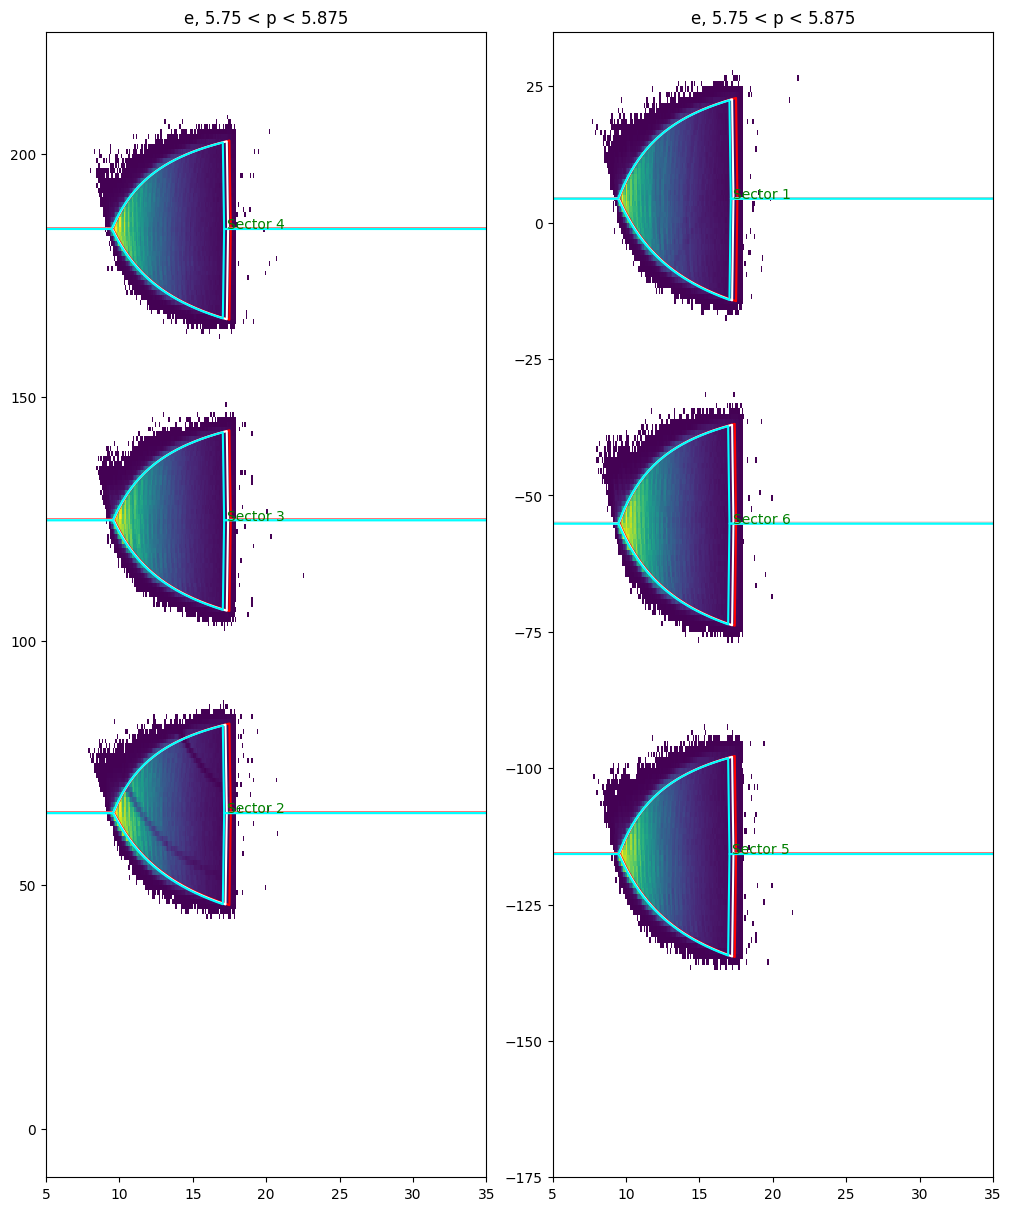

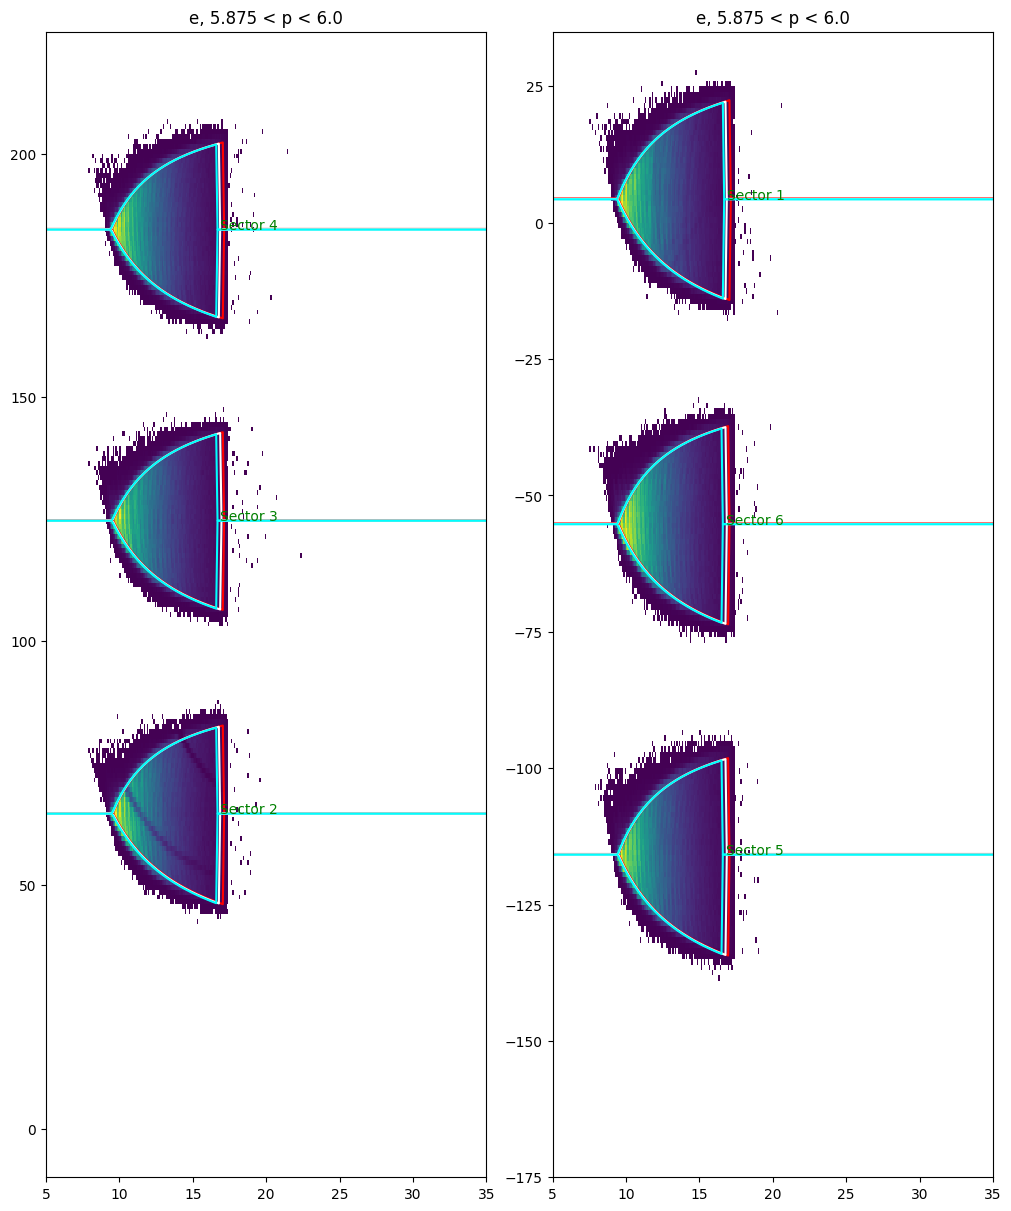

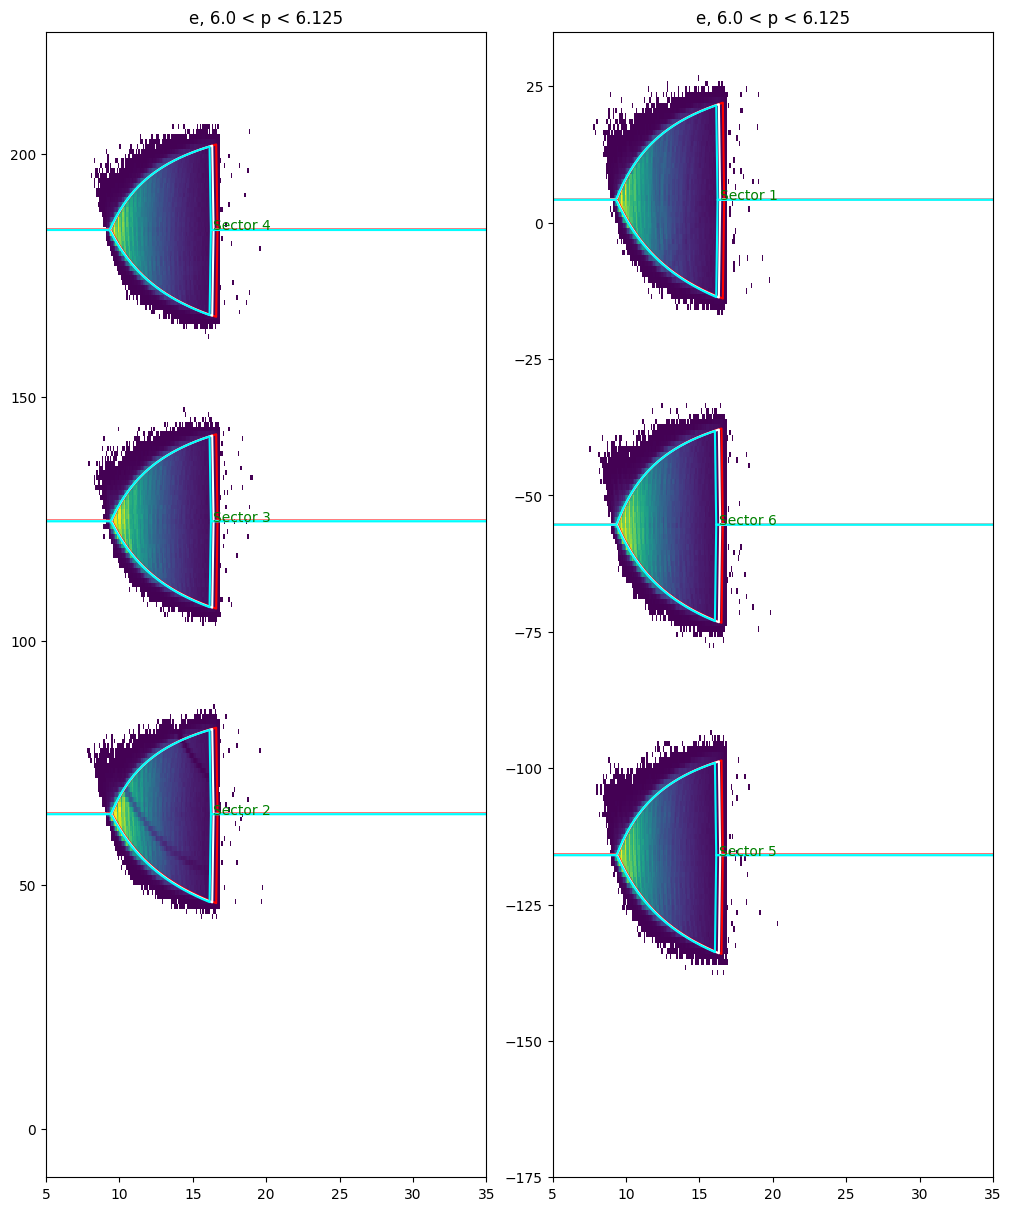

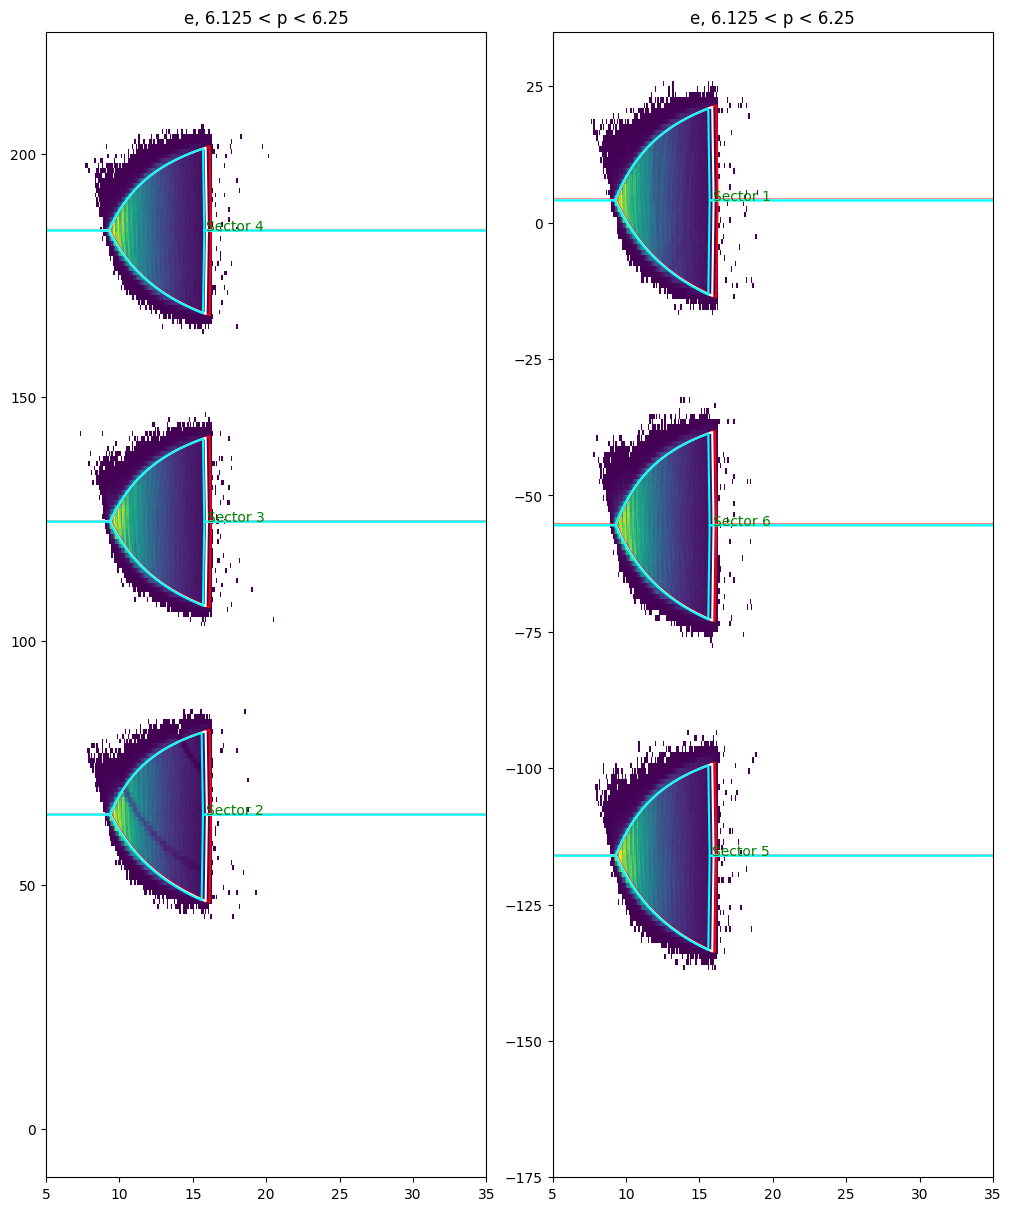

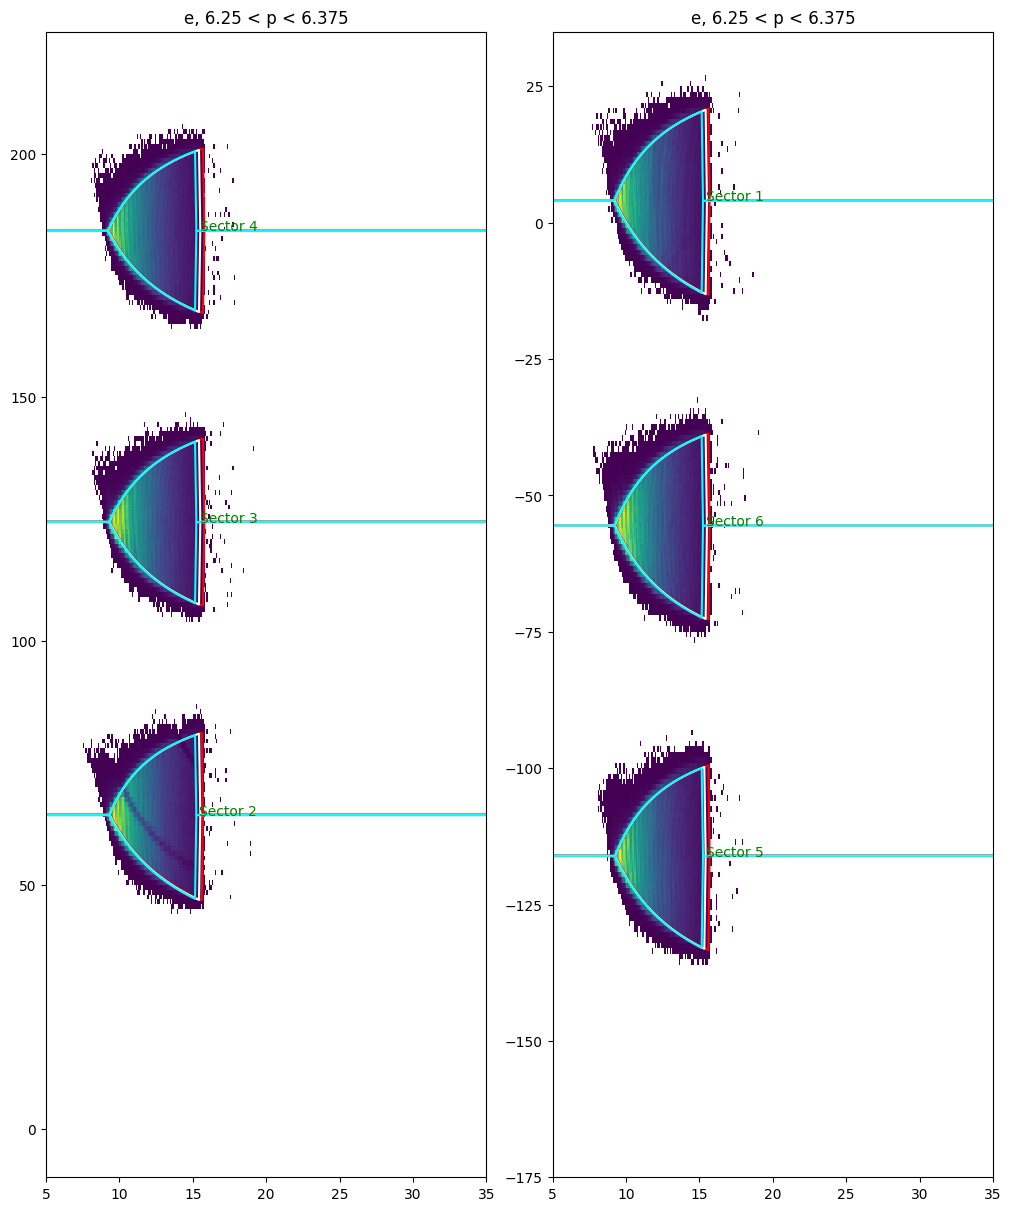

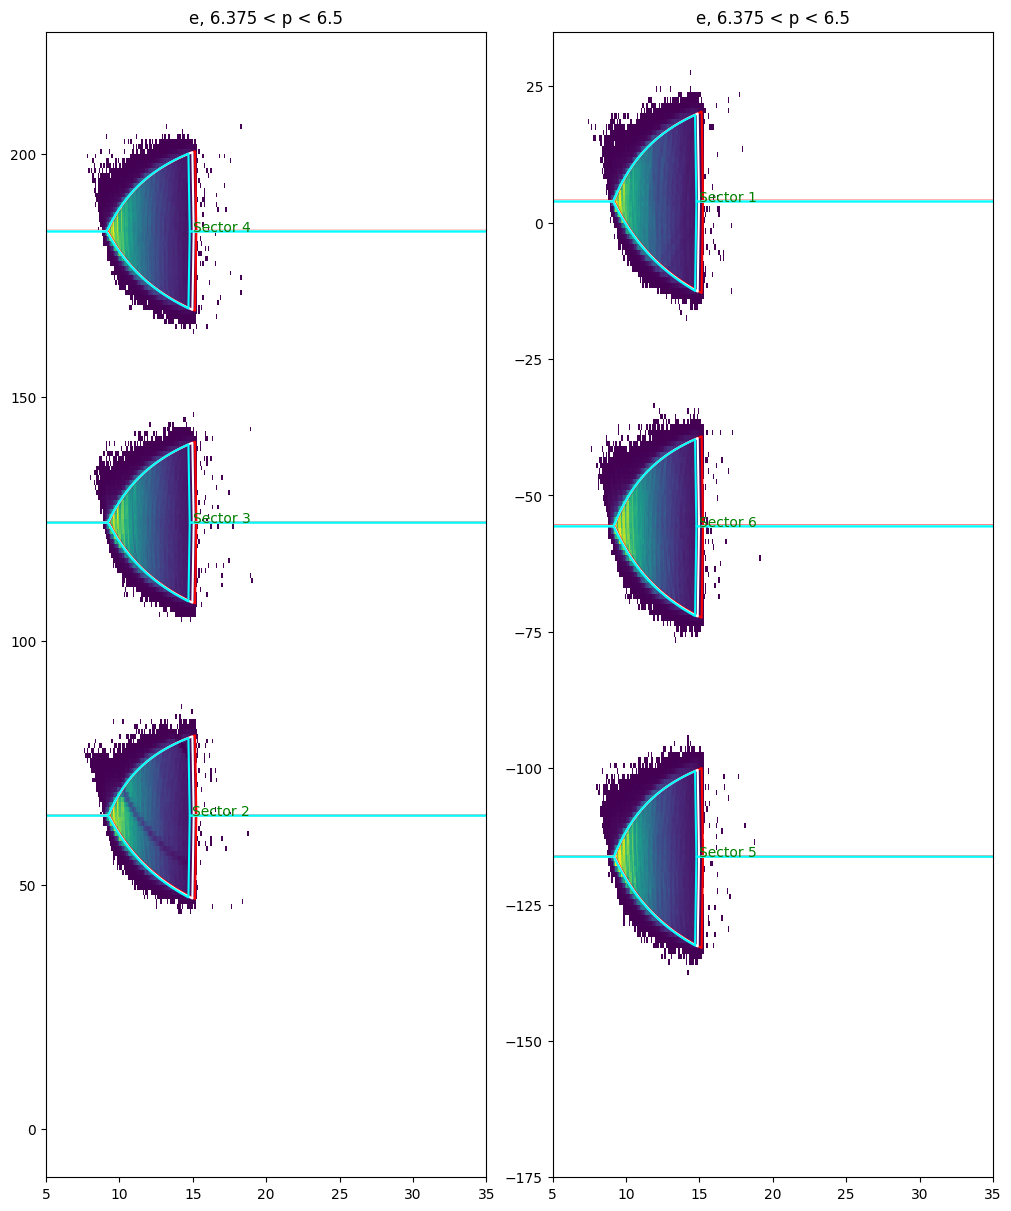

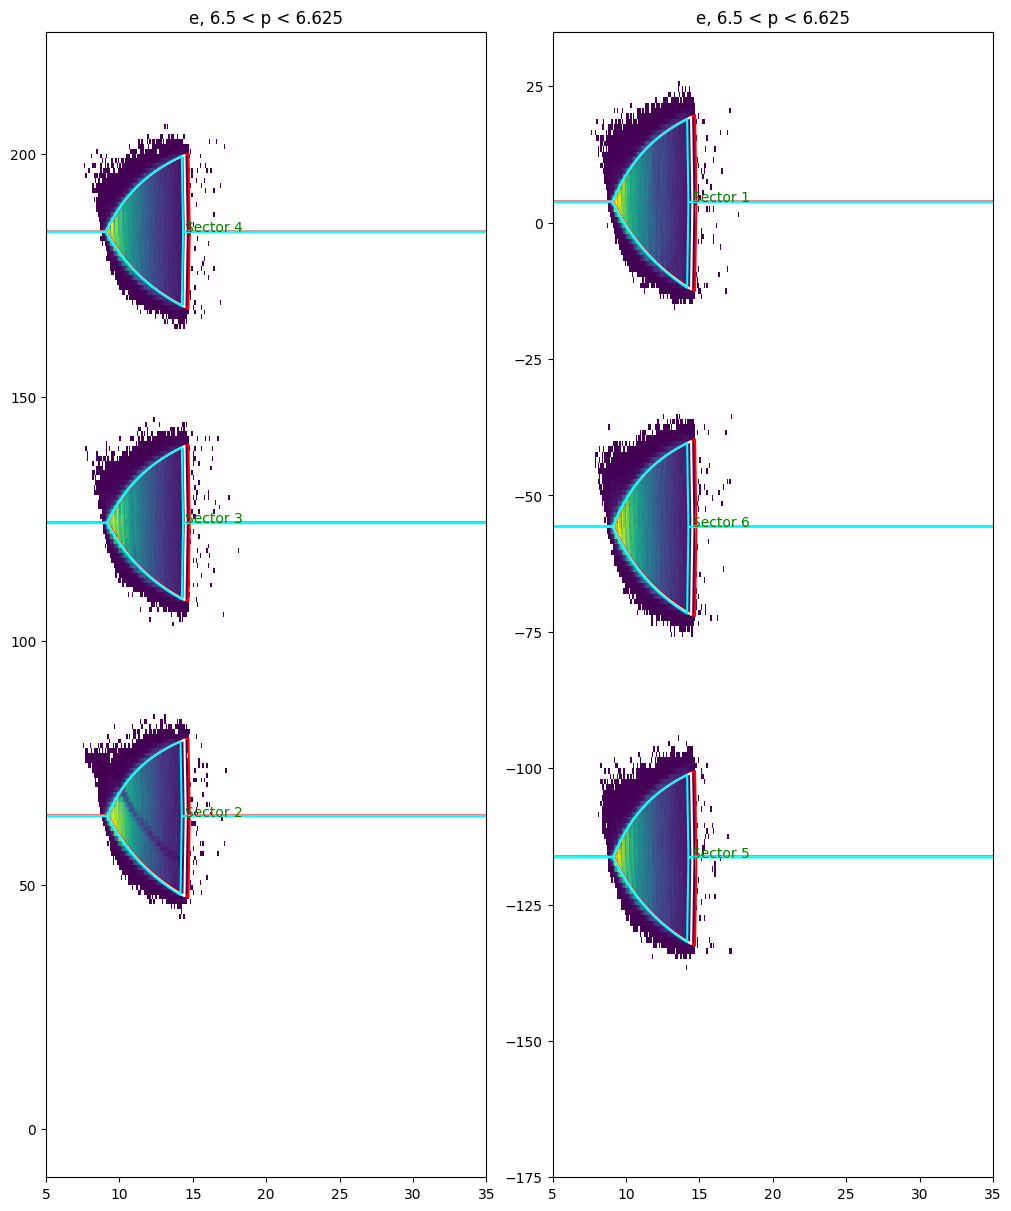

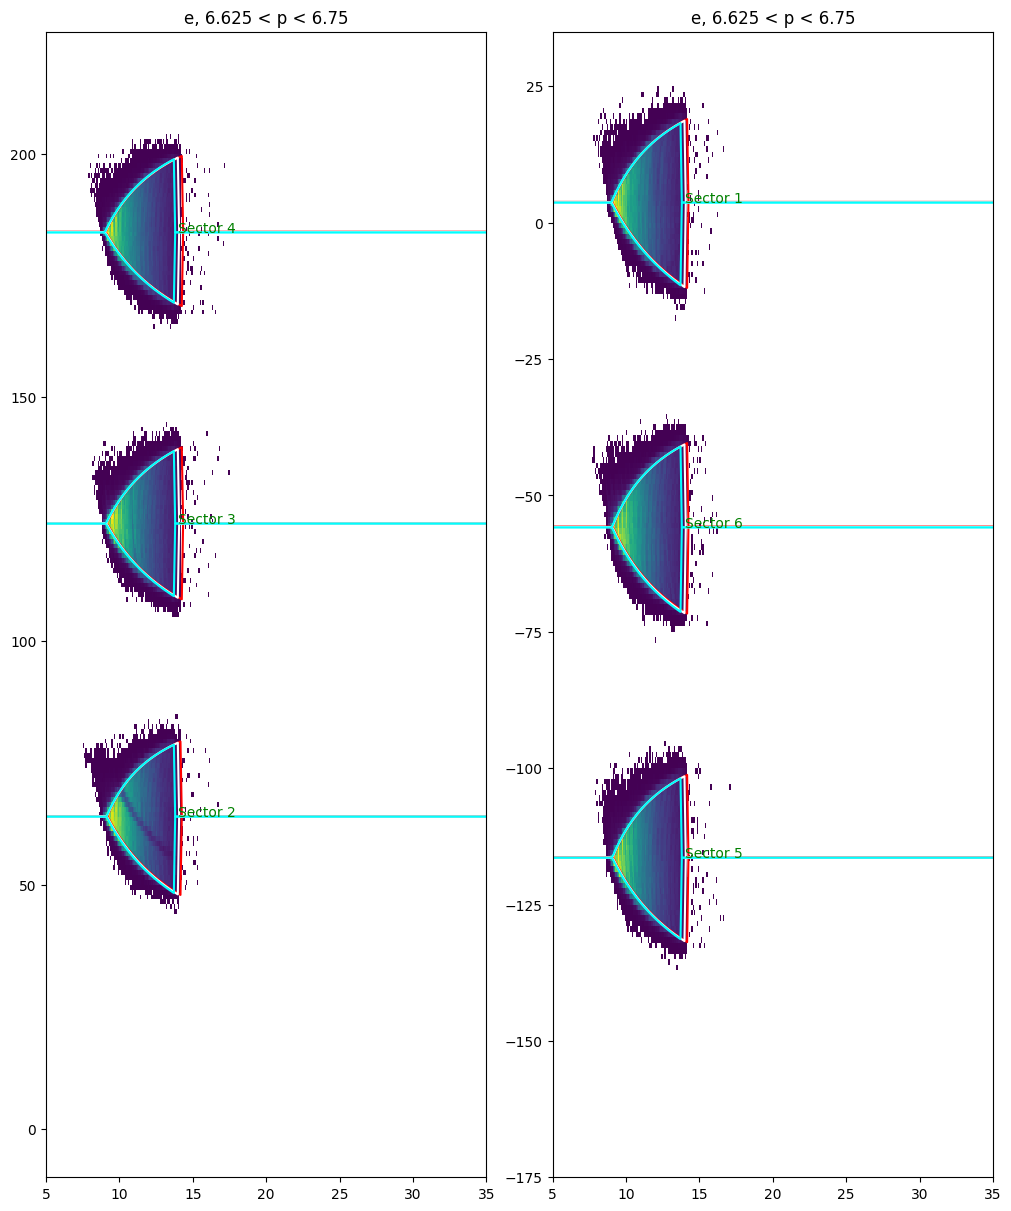

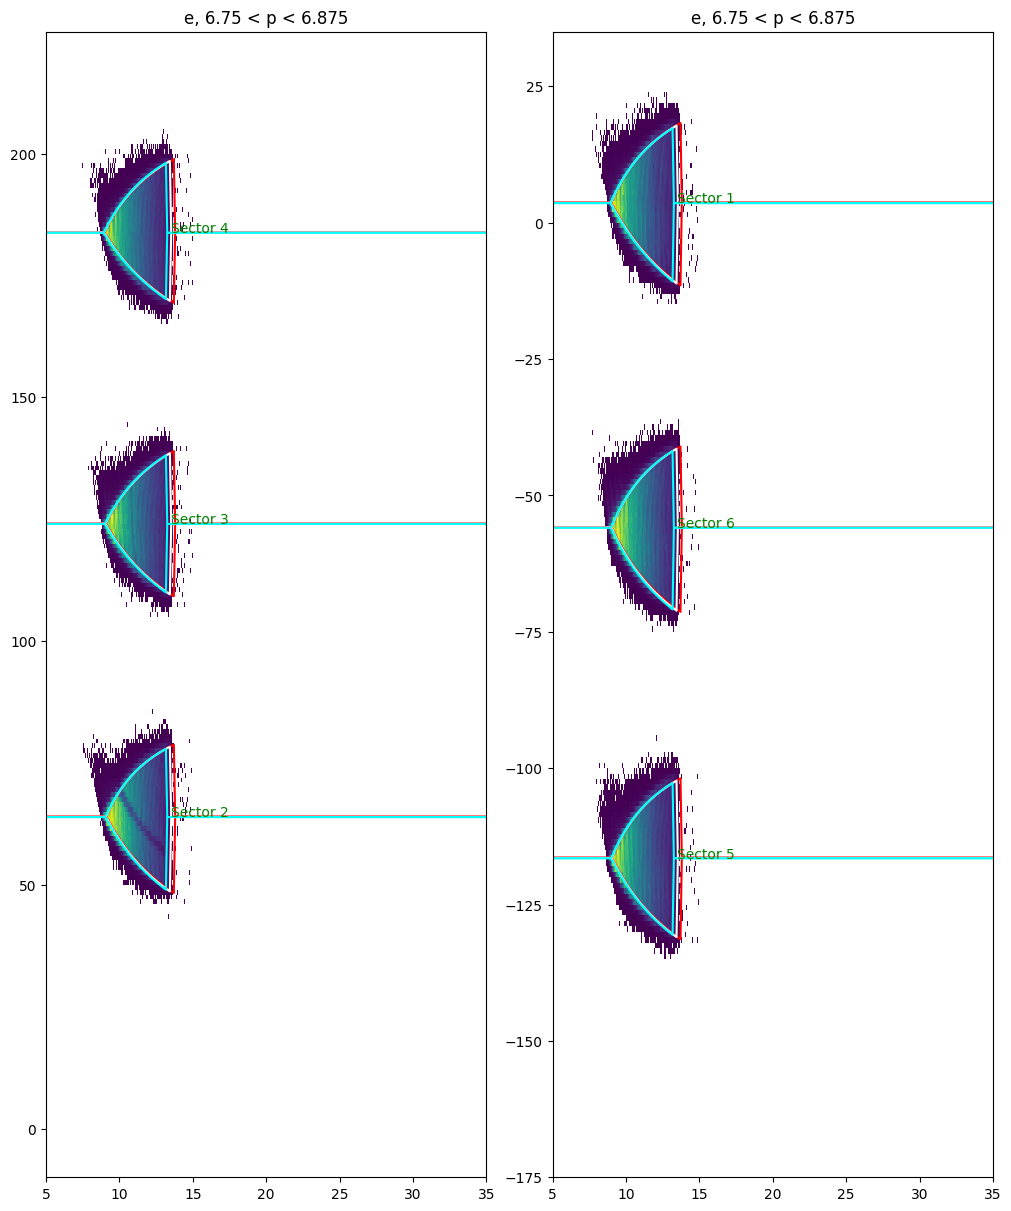

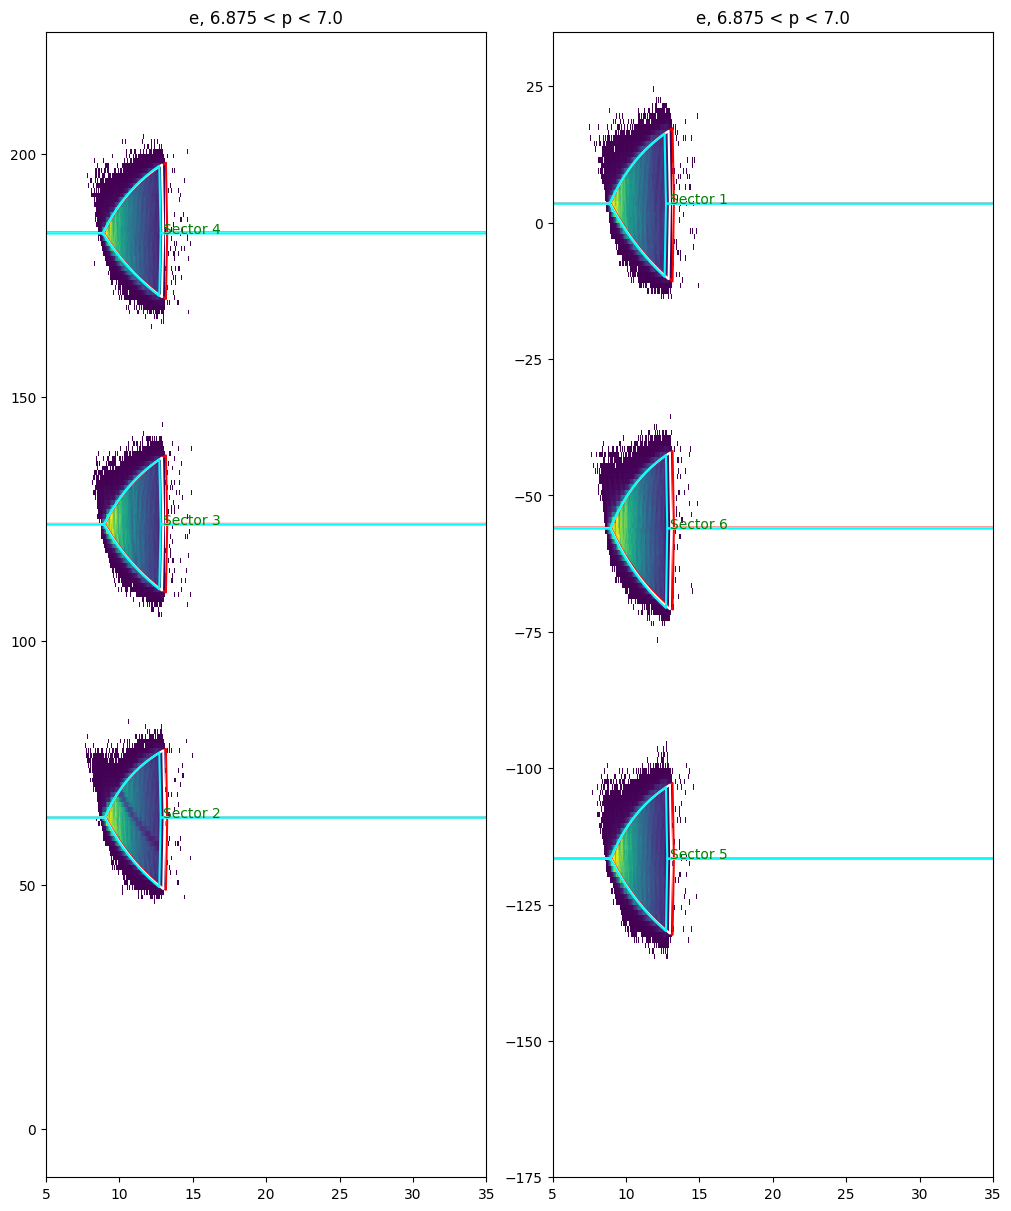

In [117]:

parIdx = 0
i = parIdx
side = 1
phi_avg =0
theta_min_fixed = 0

p_low = 0 if i == 0 else 6
p_high = 32 if i == 0 else 40
Range = range(p_low, p_high) if i==0 else reversed(range(p_low, p_high))
for p in Range:
    
    fig, ax = plt.subplots(1, 2, figsize=(10,12), layout='constrained')
    for sector in [0,1,2,3,4,5]:
        pan = 0 if sector in [1,2,3] else 1
        
        
        plot_fit(parIdx, p, sector, ax[pan])
        y_mean, x_mean, max_theta = getHistMean(parIdx, p, sector)
        low_val = 10#np.min(low) if np.min(low) > 0 else 10
    
        

        ax[0].set_xlim(low_val-5, 35)
        ax[1].set_xlim(low_val-5, 35)

        ax[0].set_ylim(-10, 225)
        ax[1].set_ylim(-175,35)

        p_low = 3*(parIdx == 0) + p*(5/40)
        p_mid = 3*(parIdx == 0) + (p+.5)*(5/40)
        p_high = 3*(parIdx == 0) + (p+1)*(5/40)
        phi_avg = x_mean

        max_low = poly3( p_low, *max_par[i][sector][0])        
        max_mid = poly3( p_mid, *max_par[i][sector][0])        
        max_high = poly3( p_high, *max_par[i][sector][0])        

        theta_min_params = [el_theta_min_params,pip_theta_min_params,pim_theta_min_params]
        params = [ e_params, pip_params, pim_params]
        
        low_loose, up_loose = returnMap(phi_range, p_low,
                                        theta_min_params[i], 
                                        params[i], sector, 
                                        poly3(p_low, *(mean_par[i][sector][0])), 
                                        parIdx, max_low)
        low_mid, up_mid = returnMap(phi_range, p_mid, theta_min_params[i], params[i], sector, poly3(p_mid, *(mean_par[i][sector][0])), parIdx, max_mid)
        low_tight, up_tight = returnMap(phi_range, p_high, theta_min_params[i], params[i], sector, poly3(p_high, *(mean_par[i][sector][0])), parIdx, max_high)
        
        ax[pan].text( max_mid, poly3(p_mid, *(mean_par[i][sector][0])), f"Sector {sector+1}", color='Green')


        side=-1
        ax[pan].plot( phi_range, low_loose,color='red')
        ax[pan].plot( phi_range, low_mid,color='white')
        ax[pan].plot( phi_range, low_tight,color='cyan')
        
        ax[pan].plot( phi_range, up_loose,color='red')
        ax[pan].plot( phi_range, up_mid,color='white')
        ax[pan].plot( phi_range, up_tight,color='cyan')


        #side=1
        ##ax[pan].plot( phi_range, phiFunction_fixed(phi_range, *popt_low),color='red')
      

In [133]:
out_file = ROOT.TFile("acceptanceMap_allE_final.root", "RECREATE")

pars = ['e', 'pip', 'pim']
params = ['lower_a','upper_a','lower_b', 'upper_b','theta', 'max', 'mean']
func = [ "[0] + [1]*exp([2]*(x-[3]))",
        "[0] + [1]*x*exp([2]*(x-[3])*(x-[3]))",
        "[0] + [1]/(x*x) + [2]*x + [3]/x + [4]*exp([5]*x)",
        "[0] + [1]*x + [2]*x*x + [3]*x*x*x" ]


func_list = [
    [0,0,1,1,2,3,3],
    [0,0,1,1,2,3,3],
    [1,1,1,1,2,3,3]
]
theta_min_params = [el_theta_min_params,pip_theta_min_params,pim_theta_min_params]
param_array = [ e_params, pip_params, pim_params]

f_params = [[[ROOT.TF1(f"f_"+pars[i]+f"_{sec+1}_param_"+params[j], func[func_list[i][j]], 0, 8) for j in range(len(params))] for sec in range(6)]  for i in range(len(pars))]

print(np.shape(f_params))

n_params = 4

print( theta_min_params[0])

for i in range(3): #loop through particles
    for sec in range(6): #loop through sectors
            for l in range(4): #loop through momentum dependent parameters
                f_params[i][sec][l].SetParameters(*param_array[i][l][sec])
                f_params[i][sec][l].Write()
            f_params[i][sec][4].SetParameters(*theta_min_params[i][sec])
            f_params[i][sec][4].Write()
            f_params[i][sec][5].SetParameters(*max_par[i][sec])
            f_params[i][sec][5].Write()
            f_params[i][sec][6].SetParameters(*mean_par[i][sec])
            f_params[i][sec][6].Write()

out_file.Close()


(3, 6, 7)
[array([ 5.84861426e+00, -1.67061853e+01, -3.09817183e-02,  2.50890974e+01,
       -3.07624139e-05, -6.09020516e-01]), array([ 6.80366338e+00, -1.06922876e+01, -7.21202028e-02,  2.04659102e+01,
        3.10056252e-04, -1.13312136e+01]), array([ 7.01926496e+00, -1.00229833e+01, -1.03486984e-01,  2.01825525e+01,
       -1.16545580e-11,  3.13995767e+00]), array([ 6.50394254e+00, -1.04346821e+01, -5.58532027e-02,  2.12387816e+01,
       -6.69520584e-06,  1.32799916e+00]), array([ 6.06596040e+00, -1.34391234e+01, -2.69100887e-02,  2.33448384e+01,
        1.78640417e-04, -5.85487342e+00]), array([ 6.75799254e+00, -1.08045124e+01, -7.58133203e-02,  2.04002051e+01,
       -8.32951521e-05, -1.31389726e-01])]
